# **CHE 1147 Final Project: Predicting Risk of Cholesterol**
This notebook contains the approach, analysis and models used to predict risk that a patient will have cholesterol based on demographic, lab, questionnaire, exminations and diet data. The dataset used for the preceding analysis comes from the [National Health and Nutrition Examination Survey dataset](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey).


**Authors:** Zehui Lin, Dylan Mendonca, Shimona Narang, Esmond Tang<br>
**Date of Last Revision:** 7-April-2020

**Note:** This notebook was prepared in Google Colab. The data authorization works only in Google Colab and the datasets are directly extracted from the google drive. 

## **Importing Modules**

In [0]:
#pip install rfpimp

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_curve, accuracy_score, precision_score, roc_auc_score
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
import xgboost as xgb
from functools import reduce
from ast import literal_eval
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


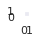

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [0]:
#plotting and display settings
sns.set(color_codes=True)
plt.figure(figsize = (0.1,0.1))
plt.grid(False)
plt.show()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [0]:
#reading csv and excel files from drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Loading Data**

In [0]:
#diet data
link_diet = 'https://drive.google.com/open?id=1N63wFTMqNYg6khqwoR9zY6oqWxZ23xdi'
fluff, id = link_diet.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('diet.csv')  
df_diet = pd.read_csv('diet.csv')

#questionnaire
link_question = 'https://drive.google.com/open?id=1ALevssQdzFhy8avg9X3qBVbO3qO8GSuk'
fluff, id = link_question.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('questionnaire.csv')  
df_questionnaire = pd.read_csv('questionnaire.csv')

#demographics
link_demographics = 'https://drive.google.com/open?id=1li048-K0gWjqd7LHrEtgeBgW0rzqGQQk'
fluff, id = link_demographics.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('demographic.csv')  
df_demographics = pd.read_csv('demographic.csv')

#examination
link_examination = 'https://drive.google.com/open?id=1jVUeZu0YSNEYkcUP6dHnmA0tGMTeJSFO'
fluff, id = link_examination.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('examination.csv')  
df_examination = pd.read_csv('examination.csv')

#lab
link_lab = 'https://drive.google.com/open?id=1oyO5qDLHuZXLrYbVjI_8M4KpZCfgFauE'
fluff, id = link_lab.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labs.csv')  
df_labs = pd.read_csv('labs.csv')

#features
link_lab = 'https://drive.google.com/open?id=1xAxPysBNy7Mf6dn4I2TSl2HGk2noMgzm'
fluff, id = link_lab.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Feature_Selection.csv')  
features = pd.read_csv('Feature_Selection.csv')

# columns with data types and codes to combine
link_lab = "https://drive.google.com/open?id=143P9zYhmNq29ONYofppv7twePM6mPwJs"
fluff, id = link_lab.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('columns_V1.csv')  
column_descriptors = pd.read_csv('columns_V1.csv')

## **3 Cleaning Up Data and Dealing with Missing Values**
In this section, we:
1. Reduce the number of features from 1390 to 156 based on our own feature picking. Considering that we had an extremely large feature set, our strategy was to split each table among the 4 of us and exclude non-relevant features on an individual discretionary basis (eg: Whether a person was a veteran or not was considered unimportant). We were generally lenient on features to pick - if we could remotely associate a feature to cholesterol, we kept it (eg: a person's socieconomic status could mean that they're healthier because they're more educated, leading to lower cholesterol levels). We did this because we didn't want our individual picks affecting our results. Also, we used this strategy to get a big subset of features which we could apply more rigorous feature picking strategies to later in the report.

2. Merge the dataframes on SEQN (Patient ID), keeping the features we selected from Step 1, and remove rows with NA values for our target variable, LBXTC (Chlolesterol). 

3. B**inarize our target variable into two categories, where levels above 240 are high (1) and levels below are borderline to low. This is based on cbc guideline. https://www.cbc.ca/news/technology/cholesterol-keeping-your-levels-in-check-1.880731

4. Deal with missing values in our feature data. We did this by:
  1. If the number of missing values in a feature for each category is 15% or less, we drop the feature.
  2. In our dataset, we noticed that categorical and numerical columns had answers such as "Refused to Answer" or "Don't Know". In some cases, "Refused to Answer" was denoted as a 7 and "Don't Know" was denoted as a 9. We went through each feature and determined what the numer representations for "Refused to Answer" and "Don't Know" was and stored these results in a CSV. We then went through each feature and converted these responses into one value (-777777) because we assumed that they translate to "missing".
  3. To impute missing values, we treated our feature set seprately by splitting it into categorical and numerical. 
  4. For categorical features, we impute missing values based on the proportions in the feature set (with this method, we also imputed -777777's i.e. missing values. Whether or not this is a good practice is very debatable)
  5. For numerical features, we generated a normally distributed set of points using the mean and std deviation of the feature. We ignored the -777777 in this case because that could skew the mean and std dev significantly because of its large magnitude. This analysis assumes that every feature is normally distributed (which isn't the case). We could've done KDE (Kernel Density Estimation) to estimate the probability distribution and then generated points but that would've been computationally expensive. Furthermore, we thought that assuming a normal distribution would add some randomly generated noise to our data

5. Split our data into train and test sets. Considering that we had a very highly imbalanced dataset, we wanted to generate 2 separate training sets. One training set using the same distribution, and one training set with equal distribution of positives and negatives. We later compare the performance of models using each of these training sets. We were also interested in exploring the generalizability of our models by creating an imbalanced test set and a balanced test set. If the model performs equally well on both an imbalanced and balanced test set, then, we can say that the model has "learned" some rules to assign 0s and 1s. 

### 3.1 Reducing Feature Set Based on Hand-Picked Features

In [0]:
# Features contains a list of features we hand picked
features.head()

,Feature Name,Code Name,Missing Values,Dataset
0,Highest Grade or Education Level,DMDEDUC2,2282,demographics
1,What Country were you born in?,DMDBORN4,0,demographics
2,Highest Grade or Education Level,DMDEDUC3,5342,demographics
3,People in Household,DMDHHSIZ,0,demographics
4,People in Family,DMDFMSIZ,0,demographics


In [0]:
# Storing the feature codes (as is in the database) in a list
code_names = features.loc[:,'Code Name'].to_list()
print("First 10 Codes:", code_names[:10])

First 10 Codes: ['DMDEDUC2', 'DMDBORN4', 'DMDEDUC3', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'INDFMIN2', 'RIAGENDR']


In [0]:
# Selecting Patient ID and Cholesterol columns
df_labs = df_labs[['SEQN', 'LBXTC']]

### 3.2 Merge Dataframes Removing NA Cholesterol Values

In [0]:
# Creating a list of dataframes
df_list = [df_labs, df_diet, df_demographics,df_examination, df_questionnaire]

# Merging all dataframes on SEQN (patient ID)
df = reduce(lambda left,right: pd.merge(left,right,on='SEQN'), df_list)

In [0]:
# Shape of dataframe
df.shape

(9813, 1390)

In [0]:
# Appending Patient ID and Cholesterol to code_names (i.e. columns to keep)
code_names.append('SEQN')
code_names.append('LBXTC')

In [0]:
# Creating dataframe with columns of interest
df = df[code_names]

In [0]:
# Shape of dataframe
df.shape

(9813, 152)

In [0]:
# Describing some statistics of cholesterol lab measurements
display(df[['LBXTC']].describe())
print("% Null Cholesterol:", df['LBXTC'].isnull().sum()*100/df.shape[0])

,LBXTC
count,7624.000000
mean,179.534103
std,40.954000
min,69.000000
25%,151.000000
50%,175.000000
75%,204.000000
max,813.000000


% Null Cholesterol: 22.307143585040254


In [0]:
# Dropping rows with no target
df.dropna(axis = 0, subset= ['LBXTC'], inplace = True)

In [0]:
# Printing new shape
df.shape

(7624, 152)

### 3.3 Binarize Cholesterol Target Variable

In [0]:
# Binarizing the target
df['target'] = np.where([x >= 240 for x in df['LBXTC']],1,0)

In [0]:
print("Split of Target Variable:")
df['target'].value_counts()*100/df.shape[0]

Split of Target Variable:


0    91.972718
1    8.027282 
Name: target, dtype: float64

In [0]:
# Setting up X and Y
Y = df['target'].reset_index(drop=True)
X = df.drop(['LBXTC', 'target', 'SEQN'], axis = 1).reset_index(drop=True)

### 3.4 Handling Missing Features

In [0]:
# deomgraphic feature names
demo_features = features[features['Dataset'] =='demographics']['Code Name'].to_list()
# diet feature names
diet_features = features[features['Dataset'] =='diet']['Code Name'].to_list()
# examinations feature names
exam_features = features[features['Dataset'] =='examinations']['Code Name'].to_list()
# questionnaire feature names
question_features = features[features['Dataset'] =='questionnaire']['Code Name'].to_list()

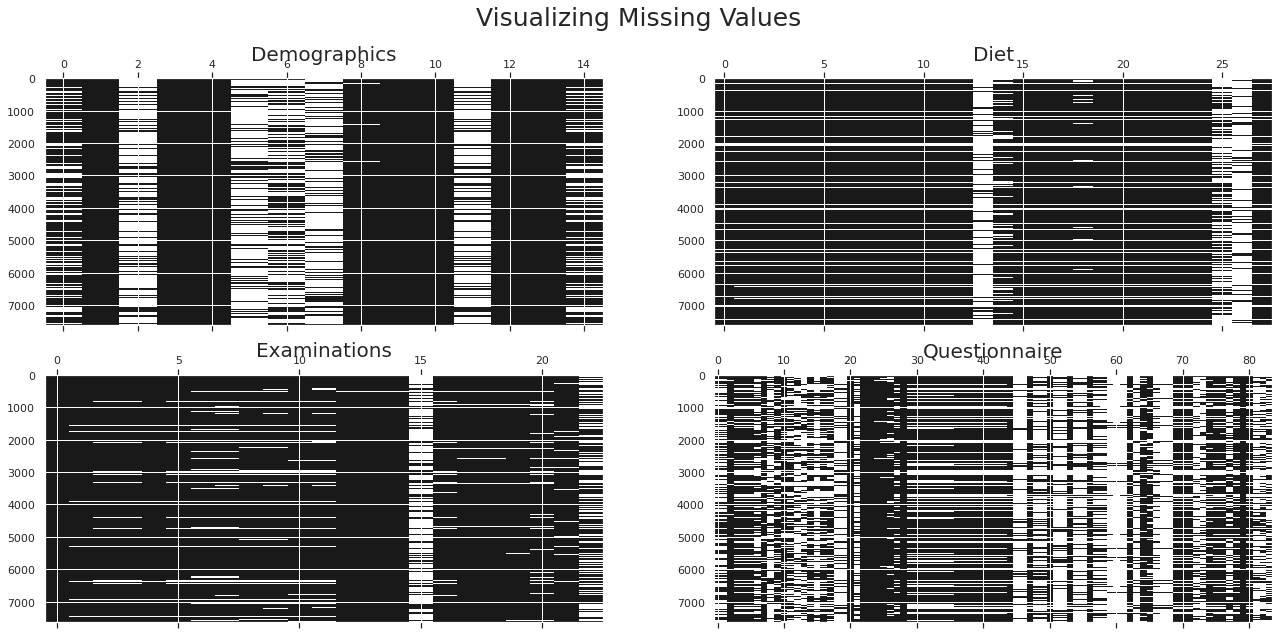

In [0]:
# Spy Plot by dataset type
fig, axs = plt.subplots(2, 2, figsize = (22,10))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

ax1.spy(np.array(X.loc[:,demo_features].fillna(0)), aspect = 'auto')
ax2.spy(np.array(X.loc[:,diet_features].fillna(0)), aspect = 'auto')
ax3.spy(np.array(X.loc[:,exam_features].fillna(0)), aspect = 'auto')
ax4.spy(np.array(X.loc[:,question_features].fillna(0)), aspect = 'auto')
ax1.set_title("Demographics", size = 20)
ax2.set_title("Diet", size = 20)
ax3.set_title("Examinations", size = 20)
ax4.set_title("Questionnaire", size = 20)
fig.suptitle("Visualizing Missing Values", fontsize=25)
plt.show()

In [0]:
# Dropping columns based on if missing values (%) for each target category has 15% or less missing values
# Columns to drop contains series where True is a column that needs to be dropped and False is a column that needs to be kept
columns_to_drop = (df.groupby(by='target').apply(lambda x: x.isnull().sum()*100/df.shape[0]) > 15).any()
# Removing the SEQN, target and cholesterol columns
columns_to_drop.drop(['SEQN','target','LBXTC'], inplace = True)
cleaned_X = X.loc[:, ~columns_to_drop]

In [0]:
# Getting categorical and numerical columns
categorical_columns = column_descriptors[column_descriptors['Type']=='categorical']['Code Name'].to_list()
numerical_columns = column_descriptors[column_descriptors['Type']=='numerical']['Code Name'].to_list()

In [0]:
categories_to_combine = literal_eval(column_descriptors[column_descriptors['Code Name'] == 'CBD120']['Refused'].values[0])

In [0]:
# Some categorical and numerical columns have categories denoted for answers such
# as "Refused to Answer" or "Don't Know". I will combine these into one group
# So for a feature, if 7 denotes "Refused to Answer" and 9 denotes "Don't Know"
# they are combined into one category
# descriptors
column_descriptors['Refused'].fillna('[]', inplace=True)
cleaned_X = cleaned_X.copy()
for column_name in cleaned_X:
  categories_to_combine = literal_eval(column_descriptors[column_descriptors['Code Name'] == column_name]['Refused'].values[0])
  indexes_to_combine = cleaned_X[column_name].isin(categories_to_combine)
  cleaned_X.loc[indexes_to_combine, column_name] = -777777

#### 3.4.1 Imputation: Impute Categorical variables According to Proportion in Feature

In [0]:
# Function to fill NA values in categorical columns by proportions
def fill_cats(series_values):
  series_ = series_values.copy()
  counts_ = series_.value_counts()/len(series_)
  na_ = series_.isna()
  choices = np.random.choice(counts_.index, size = na_.sum(), p = (counts_.values)/(counts_.values).sum())
  series_.loc[na_] = choices

  return series_

In [0]:
# Applying the function to each categorical column
filled_X = cleaned_X[categorical_columns].apply(lambda x: fill_cats(x))

#### 3.4.2 Imputation: Impute Numerical Features By Generating Randomly Distributed Data Between Mean and 1 Std Dev of Mean

In [0]:
# Function to fill NA values in numerical columns by sampling from normal distribution
def fill_nums(series_values):
  series_ = series_values.copy()
  mean_, std_ = series_[series_ != 777777].mean(), series_[series_ != 777777].std()
  na_ = series_.isna()
  choices = np.random.normal(loc = mean_, scale = std_, size = na_.sum())
  series_.loc[na_] = choices

  return series_

In [0]:
# Applying the function to each numerical column
filled_X = pd.concat([filled_X, cleaned_X[numerical_columns].apply(lambda x: fill_nums(x))], axis=1 )

### 3.5 Create Train and Test Sets

In [0]:
# This function will create a balanced set of data given X and Y
# This function assumes that target 1 will have a lower prevalence in the data
# This also assumes that there are no missing values in the targets
def create_balanced_set(X, Y, random_state):
  a = X.copy()
  b = Y.copy()

  df = pd.concat([a,b], axis = 1)
  target_one = df[df['target'] == 1]
  target_zero = df[df['target'] == 0]
  number_of_indices_to_remove = target_zero.shape[0] - target_one.shape[0]
  indices_to_remove = target_zero.sample(number_of_indices_to_remove, random_state = random_state).index
  df = df.drop(indices_to_remove)
  b = df['target']
  a = df.drop('target', axis = 1)

  return a, b

In [0]:
# This function will take X and Y and return imbalanced train, balanced_train,
# imbalanced test and balance test sets
def create_splits(X, Y, test_size, random_state):
  x = X.copy()
  y = Y.copy()

  X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=test_size, 
                                                      random_state = random_state)
  
  imbalanced_train = X_train, Y_train
  imbalanced_test = X_test, Y_test

  balanced_train = create_balanced_set(X = X_train, Y = Y_train, random_state=random_state)
  balanced_test = create_balanced_set(X = X_test, Y = Y_test, random_state=random_state)

  return imbalanced_train, balanced_train, imbalanced_test, balanced_test

In [0]:
# Creating the imbalanced/balanced train and test sets
imbalanced_train, balanced_train, imbalanced_test, balanced_test = create_splits(filled_X, Y, 0.3, 2)

In [0]:
# class distribution in imbalanced sets
print("High Cholesterol cases in balanced training set: ", round((balanced_train[1] == 1).sum()/len(balanced_train[1])*100,2), "%")
print("High Cholesterol cases in balanced testing set: ", round((balanced_test[1] == 1).sum()/len(balanced_test[1])*100,2), "%")

High Cholesterol cases in balanced training set:  50.0 %
High Cholesterol cases in balanced testing set:  50.0 %


In [0]:
# class distribution in test set and training set
print("High Cholesterol cases in imbalanced training set:", round((imbalanced_train[1] == 1).sum()/len(imbalanced_train[1])*100,2), "%")
print("High Cholesterol cases in imbalanced test set:", round((imbalanced_test[1] == 1).sum()/len(imbalanced_test[1])*100,2), "%")

High Cholesterol cases in imbalanced training set: 7.83 %
High Cholesterol cases in imbalanced test set: 8.48 %


In [0]:
#to test the model on unequal test set (to be changed)
# X_dummy = X_test_uneq
# Y_dummy = Y_test_uneq
# print(X_test_uneq.shape)
# print(X_test_eq.shape)

## **4. Exploratory Data Analyis, PCA and standardizing data**

In [0]:
df_eda = pd.concat((filled_X, Y), axis = 1)

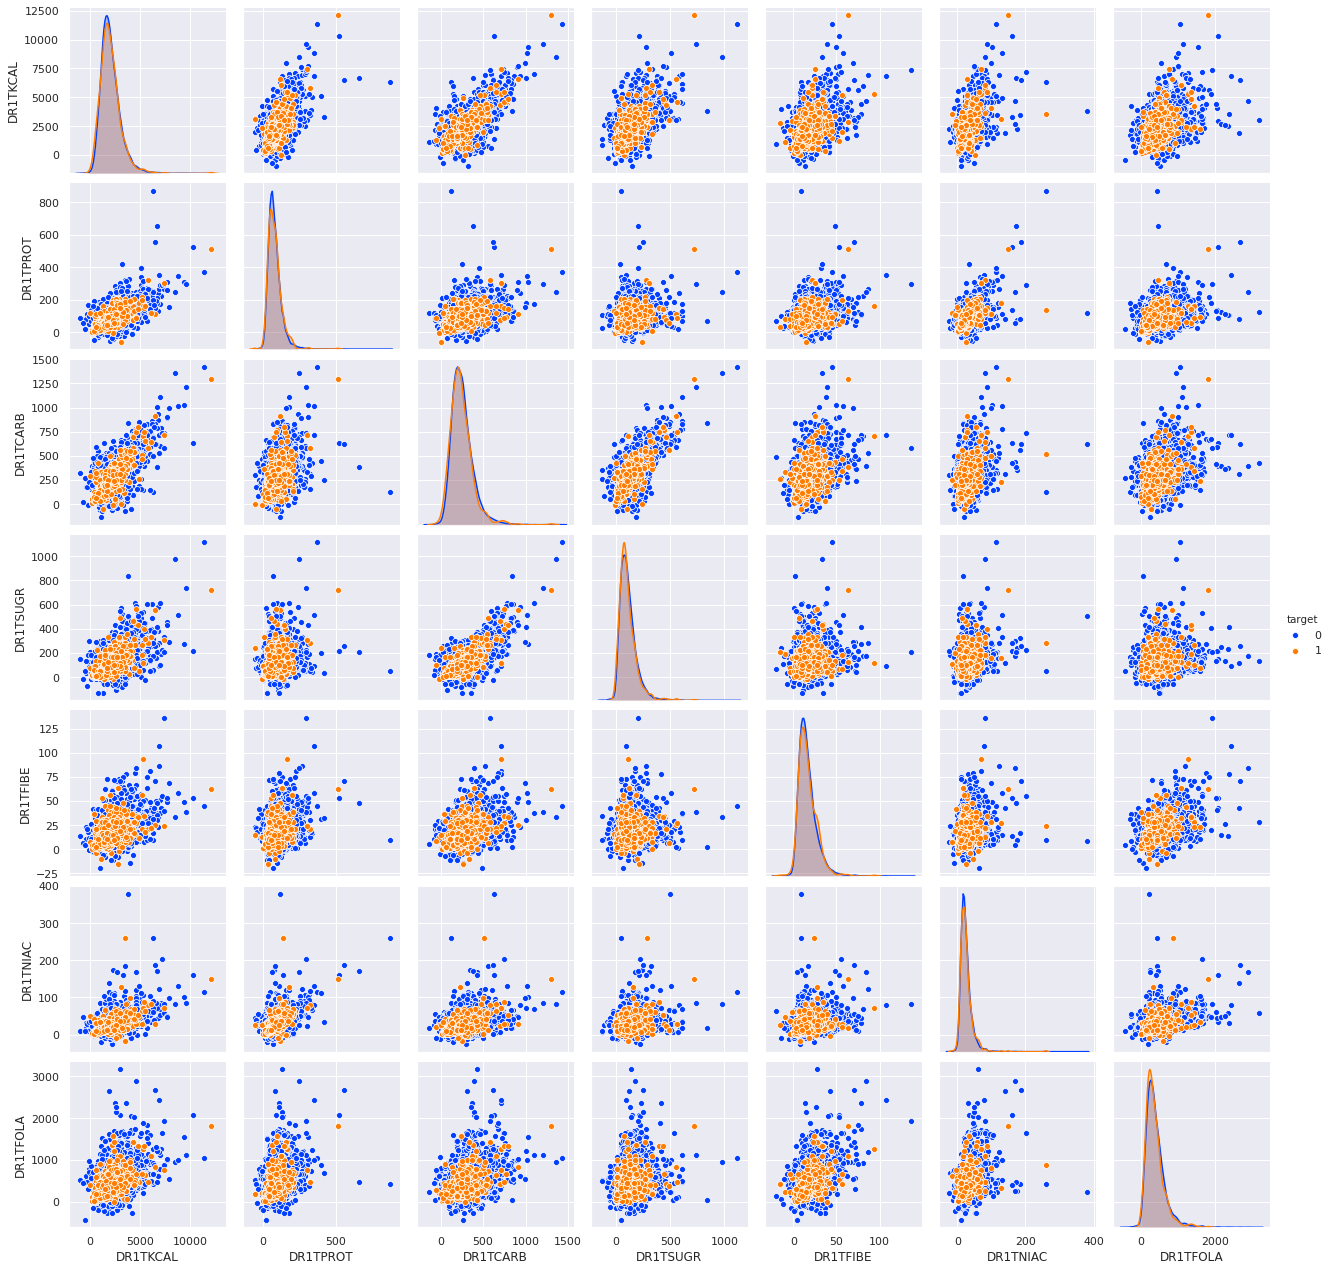

In [0]:
#plotting pairplots for few features
g = sns.pairplot(vars = ['DR1TKCAL',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TNIAC',
 'DR1TFOLA'] , hue = 'target' ,data = df_eda, palette= 'bright')

Thus,we see that most of the features have overlapping classes

## **4.1 Standardize data**

Standardization is the process of putting different variables on the same scale. This process allows you to compare scores between different types of variables.

In [0]:
#using sklearn library StandardScaler
scaler = preprocessing.StandardScaler()

In [0]:
# Selecting data. Here I select a balanced training set and an imbalanced test 
# set
X_train = balanced_train[0]
Y_train = balanced_train[1]

X_test = imbalanced_test[0]
Y_test = imbalanced_test[1]

In [0]:
#when using using equal weights for training set and testig set
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [0]:
cleaned_X_std = scaler.fit_transform(filled_X)

cleaned_X_std = pd.DataFrame(cleaned_X_std, columns = filled_X.columns, index = Y.index)

In [0]:
#Numerical features for which distribution is plotted
distplot_list = ['RIDAGEYR', 'BMXWAIST','BMXWT', 'DR1TMAGN', 'BMXBMI']

Below, with the distribution plots we can see the nature of two classes for few features

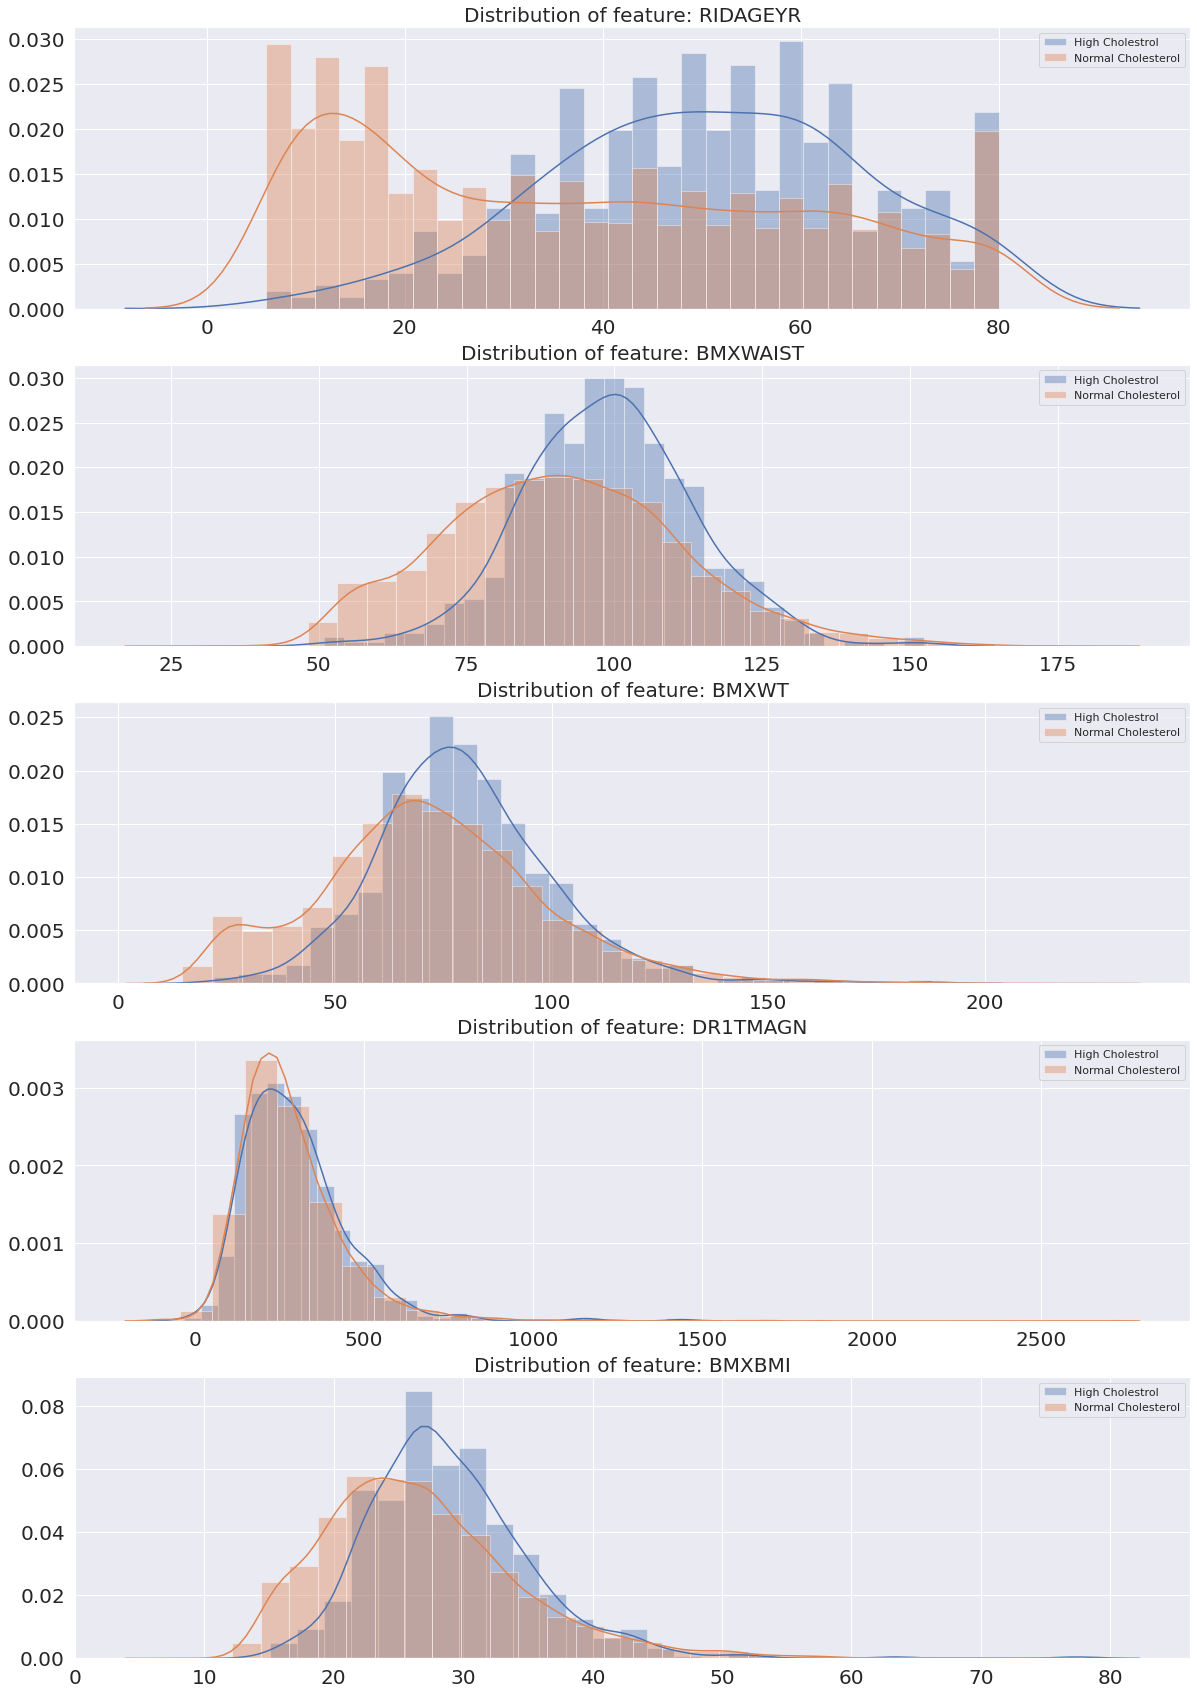

In [0]:
#plotting distribution plots
import matplotlib.gridspec as gridspec
features_plot=[f for f in filled_X[distplot_list]]
nplots=np.size(features_plot)
plt.figure(figsize=(20,6*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features_plot):
    ax = plt.subplot(gs[i])
    sns.distplot(filled_X[feat][Y==1], bins=30)
    sns.distplot(filled_X[feat][Y==0],bins=30)
    ax.legend(['High Cholestrol', 'Normal Cholesterol'],loc='best')
    ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title('Distribution of feature: ' + feat, size = 20)
    plt.savefig("{}.png".format(feat))

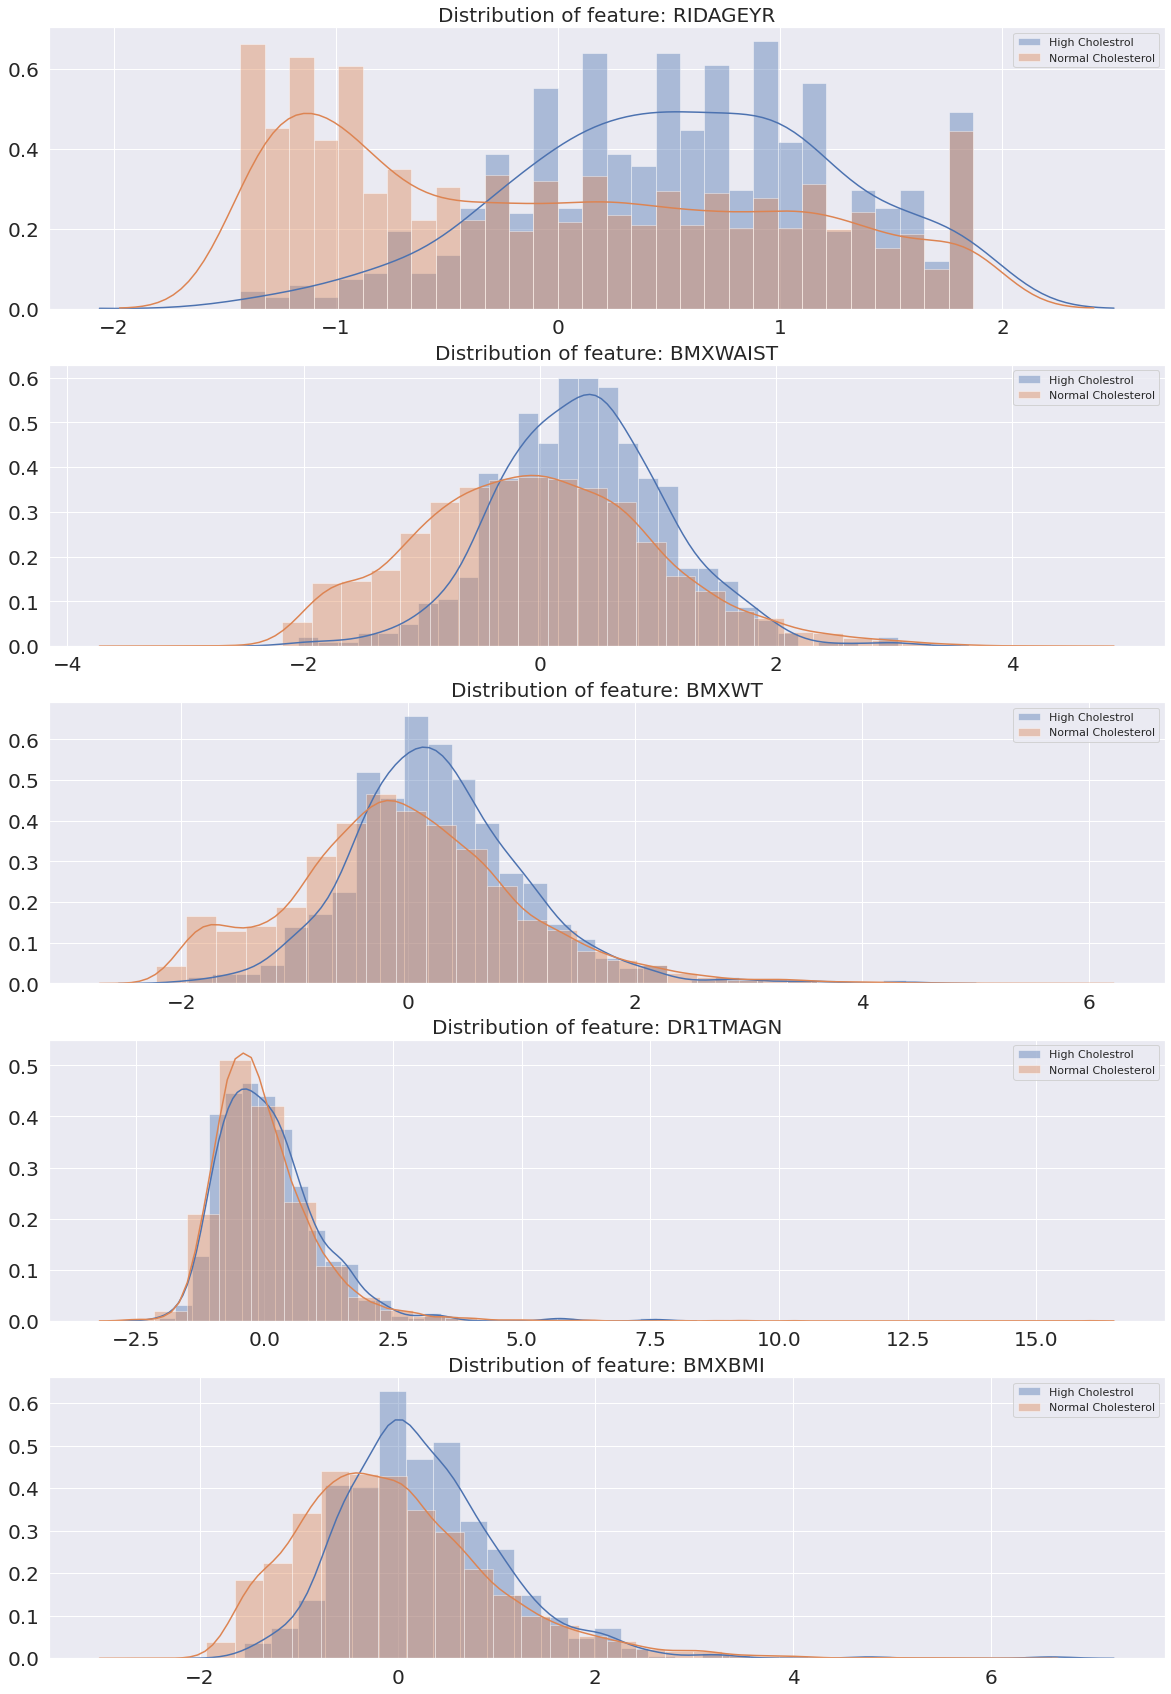

In [0]:
#plotting distribution plots
import matplotlib.gridspec as gridspec
features_plot=[f for f in cleaned_X_std[distplot_list]]
nplots=np.size(features_plot)
plt.figure(figsize=(20,6*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features_plot):
    ax = plt.subplot(gs[i])
    sns.distplot(cleaned_X_std[feat][Y==1], bins=30)
    sns.distplot(cleaned_X_std[feat][Y==0],bins=30)
    ax.legend(['High Cholestrol', 'Normal Cholesterol'],loc='best')
    ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title('Distribution of feature: ' + feat, size = 20)
    plt.savefig("{}.png".format(feat))

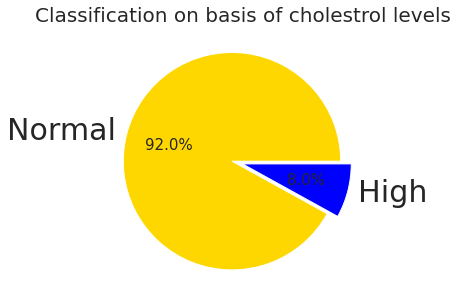

In [0]:
colors = ['gold', 'blue']
plt.figure(figsize = (8,5))
patches, texts, autotexts = plt.pie([Y.value_counts()[0], Y.value_counts()[1]], labels = ['Normal', 'High'], explode = (0.1,0), autopct='%1.1f%%', colors = colors)
texts[0].set_fontsize(30)
texts[1].set_fontsize(30)
autotexts[1].set_fontsize(15)
autotexts[0].set_fontsize(15)
plt.title('Distribution of Target Variable', size = 20)
plt.show()

From the plots above we can observe overlap of classses for almost all features, hence we need to stratgise to deal with the overlapping classes.

The distribution of target variables is concerning. We want to make sure that our training set is balanced. However, in real life, considering that we will probably encounter patients with this distribution of data, we will use an imbalanced test set. 

In [0]:
'''
#when using using unequal weights for training set and testig set
X_train_std = scaler.fit_transform(X_train_uneq)
X_test_std = scaler.transform(X_test_uneq)

#for using a common name, irresepective of the type of data split
Y_train = Y_train_uneq
Y_test = Y_test_uneq
'''

'\n#when using using unequal weights for training set and testig set\nX_train_std = scaler.fit_transform(X_train_uneq)\nX_test_std = scaler.transform(X_test_uneq)\n\n#for using a common name, irresepective of the type of data split\nY_train = Y_train_uneq\nY_test = Y_test_uneq\n'

In [0]:
# PCA
pca = decomposition.PCA(n_components=5, svd_solver='full')
pca_scores = pca.fit_transform(cleaned_X_std)

In [0]:
scores_pd = pd.DataFrame(data = pca_scores, 
                         columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5'],
                         index = cleaned_X_std.index)

In [0]:
loadings_pd = pd.DataFrame(data = pca.components_.T, 
                           columns = ['PC1', 'PC2', 'PC3','PC4','PC5'],
                           index = cleaned_X_std.columns)

In [0]:
features[features['Code Name'].isin(loadings_pd.index.tolist())][['Code Name', 'Dataset']]
#features[''].isin(loadings_pd.index.tolist())
# {loading:" " for loading in loadings_pd.index}

,Code Name,Dataset
1,DMDBORN4,demographics
3,DMDHHSIZ,demographics
4,DMDFMSIZ,demographics
5,DMDHHSZA,demographics
6,DMDHHSZB,demographics
...,...,...
128,PAD680,questionnaire
130,PAQ710,questionnaire
131,PAQ715,questionnaire
138,SMD460,questionnaire


In [0]:
mapping = loadings_pd.merge(features, how='left', right_on = 'Code Name', left_index=True)[['Code Name', 'Dataset']]

In [0]:
# mapping['Dataset'].value_counts()
colors = {'diet': 'b', 'questionnaire': 'm', 'examinations':'y', 'demographics':'k'}
mapping['Color'] = mapping['Dataset'].map(colors)
mapping = mapping.reset_index(drop=True)

In [0]:
def myplot(scores,loadings,loading_labels=None,score_labels=None, y_target = None, mapping = None):
    # adjusting the scores to fit in (-1,1)
    xt = scores[:,0]
    yt = scores[:,1]
    n = loadings.shape[0]
    scalext = 1.0/(xt.max() - xt.min())
    scaleyt = 1.0/(yt.max() - yt.min())
    xt_scaled = xt * scalext
    yt_scaled = yt * scaleyt
    # adjusting the loadings to fit in (-1,1)
    p = loadings
    p_scaled = preprocessing.MaxAbsScaler().fit_transform(p)
    
    #plt.scatter(xs * scalex,ys * scaley, s=10)
    for count,((x,y), label) in enumerate(zip(np.vstack((xt_scaled, yt_scaled)).T,score_labels)):
        plt.text(x, y, label, ha='center', size=8, color='red' if y_target[count] == 1 else 'green')
    
    for i in range(n):
        plt.arrow(0, 0, p_scaled[i,0], p_scaled[i,1], color = mapping.loc[i, 'Color'],alpha = 0.5)
        if loading_labels is None:
            plt.text(p_scaled[i,0], p_scaled[i,1], "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(p_scaled[i,0], p_scaled[i,1], loading_labels[i], color = mapping.loc[i, 'Color'], ha = 'center', va = 'center', size=12)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1), fontsize=20);
    plt.ylabel("PC{}".format(2), fontsize=20);
    plt.tick_params(labelsize=16)
    plt.grid()

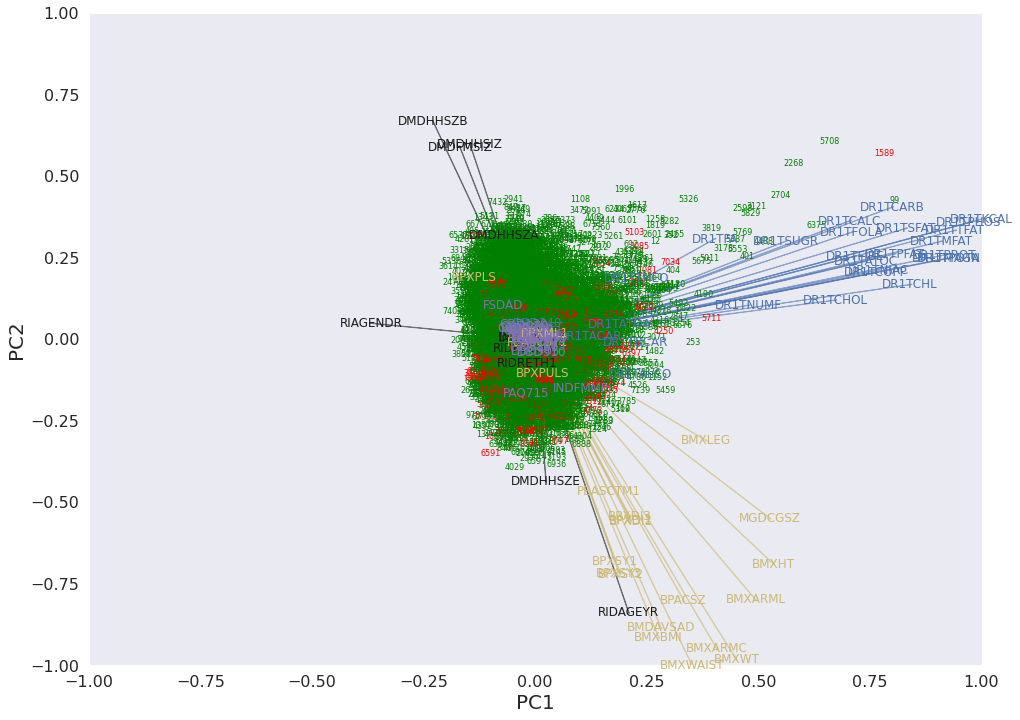

In [0]:
plt.rcParams["figure.figsize"] = [16,12]
myplot(pca_scores[:,:2],
       loadings_pd.iloc[:,:2],
       loading_labels=loadings_pd.index,
       score_labels=scores_pd.index,
       y_target=Y,
       mapping=mapping)
plt.show()

In [0]:
NUMBERS = [1589, 5708, 2268,2704, 99, 5829, 6375, 0,1,2]
display(filled_X.iloc[NUMBERS,:])
display(cleaned_X.iloc[NUMBERS,:])

,DMDBORN4,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,INDFMIN2,RIAGENDR,RIDRETH1,RIDRETH3,DRQSDIET,DRD340,PEASCST1,BPACSZ,BPXPULS,FSDAD,HIQ011,HUQ010,HOD050,IND235,MCQ086,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,PAQ710,PAQ715,SMD460,DLQ060,RIDAGEYR,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TACAR,DR1TBCAR,DR1TNIAC,DR1TFOLA,DR1TFA,DR1TCHL,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TCOPP,DR1TPOTA,DR1TTHEO,DR1TALCO,PEASCTM1,BPXPLS,BPXML1,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMDAVSAD,MGDCGSZ,CBD070,CBD120,CBD130,DBD895,DBD905,DBD910,INDFMMPI,PAD680
1589,1,6,6,1,2,1,5.0,1,3,3,1.0,1.0,1,5.0,1.0,1.0,1,1,3.0,-777777.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,0.0,2.0,32.0,40.0,12108.0,513.10,1300.72,719.58,62.9,548.38,177.467,185.833,135.346,1834.0,44.01,0.53,837.0,4453.0,148.675,1814.0,858.0,1688.9,7337.0,8760.0,1441.0,4.795,14072.0,387.0,0.0,985.0,96.0,130.0,118.0,56.0,124.0,54.0,116.0,62.0,97.6,172.9,32.6,38.0,37.0,43.0,100.2,24.300000,81.7,500.0,200.0,0.0,21.0,0.0,5.0,1.958501,840.0
5708,1,2,2,0,0,0,15.0,2,5,7,2.0,1.0,1,3.0,1.0,1.0,1,1,4.0,7.0,2.0,2.0,1.0,2.0,1.0,1.0,8.0,0.0,0.0,2.0,30.0,25.0,7370.0,296.24,582.77,207.85,136.3,483.12,63.876,208.597,182.462,10.0,143.20,0.00,267.0,2432.0,81.971,1921.0,0.0,827.1,2246.0,7071.0,2725.0,13.164,10849.0,0.0,0.0,594.0,62.0,120.0,92.0,52.0,94.0,54.0,92.0,62.0,52.6,167.7,18.7,43.0,34.0,25.3,76.0,15.900000,58.7,80.0,20.0,0.0,0.0,1.0,0.0,2.550000,60.0
2268,1,3,2,0,0,0,3.0,2,4,4,2.0,1.0,1,3.0,1.0,1.0,1,1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,5.0,0.0,1.0,2.0,29.0,25.0,11361.0,370.62,1423.87,1115.50,44.8,478.16,147.104,171.616,119.275,1514.0,44.17,0.00,95.0,589.0,114.542,1043.0,247.0,1405.4,1894.0,5118.0,1232.0,7.043,8206.0,110.0,1.4,548.0,78.0,130.0,114.0,80.0,106.0,76.0,106.0,74.0,55.0,163.0,20.7,41.7,35.9,25.6,70.7,15.519994,47.6,100.0,50.0,0.0,7.0,0.0,0.0,0.230000,480.0
2704,1,5,5,0,1,0,8.0,1,3,3,2.0,1.0,1,4.0,1.0,2.0,1,1,13.0,9.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,18.0,15.0,4645.0,248.24,399.19,176.54,84.0,258.71,41.446,139.670,60.806,930.0,172.32,80.66,60.0,169.0,169.322,2878.0,2445.0,1102.3,2743.0,4946.0,1610.0,5.539,7972.0,0.0,0.0,836.0,64.0,150.0,108.0,76.0,112.0,72.0,114.0,76.0,71.3,170.5,24.5,45.5,38.0,31.4,76.0,16.700000,100.6,1714.0,342.0,25.0,0.0,0.0,0.0,2.180000,300.0
99,1,2,1,0,0,0,6.0,1,3,3,2.0,1.0,1,5.0,1.0,4.0,1,3,4.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,5.0,2.0,2.0,23.0,35.0,10293.0,523.31,633.71,213.50,53.5,412.40,89.648,125.895,165.700,1926.0,158.39,0.00,124.0,569.0,159.831,2087.0,154.0,2909.1,2350.0,11529.0,1674.0,9.408,13296.0,0.0,290.2,769.0,62.0,140.0,128.0,64.0,126.0,64.0,128.0,60.0,92.3,178.2,29.1,40.0,37.2,37.7,95.8,22.300000,110.5,350.0,40.0,30.0,10.0,0.0,0.0,1.850000,720.0
5829,1,4,4,1,0,0,2.0,2,4,4,2.0,2.0,1,3.0,1.0,3.0,1,3,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,5.0,8.0,1.0,2.0,43.0,39.0,9595.0,295.46,1210.70,735.01,38.5,411.13,132.144,169.477,82.223,1279.0,25.37,0.00,260.0,15572.0,85.696,1125.0,693.0,1229.1,3178.0,4738.0,801.0,3.758,7088.0,548.0,0.0,600.0,72.0,140.0,118.0,84.0,120.0,86.0,122.0,84.0,70.9,172.1,23.9,38.0,37.0,27.9,89.3,21.500000,80.3,300.0,642.0,0.0,0.0,0.0,0.0,0.250000,300.0
6375,1,1,1,0,0,0,3.0,1,3,3,1.0,1.0,1,5.0,1.0,1.0,1,1,3.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,21.0,27.0,6536.0,557.87,618.64,254.25,70.9,214.90,48.810,75.653,64.890,1694.0,57.23,29.25,88.0,5204.0,187.188,2663.0,1587.0,2083.4,5065.0,8070.0,1843.0,6.769,11586.0,59.0,0.0,798.0,50.0,140.0,116.0,66.0,122.0,54.0,110.0,52.0,102.3,186.4,29.4,46.4,38.5,40.6,90.6,20.500000,123.9,1000.0,200.0,0.0,6.0,10.0,0.0,0.000000,240.0
0,1,3,3,0,0,2,4.0,1,4,4,2.0,2.0,1,4.0,1.0,1.0,1,2,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,1.0,2.0,69.0,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.00,60.0,304.0,11.804,285.0,66.0,216.3,949.0,756.0,206.0,1.072,2228.0,36.0,0.0,620.0,86.0,140.0,122.0,72.0,114.0,76.0,102.0,74.0,78.3,171.3,26.7,39.2,40.2,35.3,100.0,20.600000,55.2,300.0,0.0,85.0,8.

,DMDBORN4,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,INDFMIN2,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DRQSDIET,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TACAR,DR1TBCAR,DR1TNIAC,DR1TFOLA,DR1TFA,DR1TCHL,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TCOPP,DR1TPOTA,DR1TTHEO,DR1TALCO,DRD340,PEASCST1,PEASCTM1,BPACSZ,BPXPLS,BPXPULS,BPXML1,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMDAVSAD,MGDCGSZ,CBD070,CBD120,CBD130,DBD895,DBD905,DBD910,FSDAD,HIQ011,HUQ010,HOD050,IND235,INDFMMPI,MCQ086,PAQ605,PAQ620,PAQ635,PAQ650,PAQ665,PAD680,PAQ710,PAQ715,SMD460,DLQ060
1589,1,6,6,1,2,1,5.0,1,32,3,3,1.0,40.0,12108.0,513.10,1300.72,719.58,62.9,548.38,177.467,185.833,135.346,1834.0,44.01,0.53,837.0,4453.0,148.675,1814.0,858.0,1688.9,7337.0,8760.0,1441.0,4.795,14072.0,387.0,0.0,1.0,1,985.0,5.0,96.0,1.0,130.0,118.0,56.0,124.0,54.0,116.0,62.0,97.6,172.9,32.6,38.0,37.0,43.0,100.2,24.3,81.7,500.0,200.0,0.0,21.0,0.0,5.0,1.0,1,1,3.0,-777777.0,NaN,2.0,2.0,2.0,2.0,1.0,1.0,840.0,2.0,1.0,0.0,2.0
5708,1,2,2,0,0,0,15.0,2,30,5,7,2.0,25.0,7370.0,296.24,582.77,207.85,136.3,483.12,63.876,208.597,182.462,10.0,143.20,0.00,267.0,2432.0,81.971,1921.0,0.0,827.1,2246.0,7071.0,2725.0,13.164,10849.0,0.0,0.0,1.0,1,594.0,3.0,62.0,1.0,120.0,92.0,52.0,94.0,54.0,92.0,62.0,52.6,167.7,18.7,43.0,34.0,25.3,76.0,15.9,58.7,80.0,20.0,0.0,0.0,1.0,0.0,1.0,1,1,4.0,7.0,2.55,2.0,2.0,1.0,2.0,1.0,1.0,60.0,8.0,0.0,0.0,2.0
2268,1,3,2,0,0,0,3.0,2,29,4,4,2.0,25.0,11361.0,370.62,1423.87,1115.50,44.8,478.16,147.104,171.616,119.275,1514.0,44.17,0.00,95.0,589.0,114.542,1043.0,247.0,1405.4,1894.0,5118.0,1232.0,7.043,8206.0,110.0,1.4,1.0,1,548.0,3.0,78.0,1.0,130.0,114.0,80.0,106.0,76.0,106.0,74.0,55.0,163.0,20.7,41.7,35.9,25.6,70.7,NaN,47.6,100.0,50.0,0.0,7.0,0.0,0.0,1.0,1,1,2.0,1.0,0.23,2.0,2.0,2.0,1.0,2.0,2.0,480.0,5.0,0.0,1.0,2.0
2704,1,5,5,0,1,0,8.0,1,18,3,3,2.0,15.0,4645.0,248.24,399.19,176.54,84.0,258.71,41.446,139.670,60.806,930.0,172.32,80.66,60.0,169.0,169.322,2878.0,2445.0,1102.3,2743.0,4946.0,1610.0,5.539,7972.0,0.0,0.0,1.0,1,836.0,4.0,64.0,1.0,150.0,108.0,76.0,112.0,72.0,114.0,76.0,71.3,170.5,24.5,45.5,38.0,31.4,76.0,16.7,100.6,1714.0,342.0,25.0,0.0,0.0,0.0,2.0,1,1,13.0,9.0,2.18,2.0,1.0,1.0,2.0,1.0,1.0,300.0,2.0,2.0,1.0,2.0
99,1,2,1,0,0,0,6.0,1,23,3,3,2.0,35.0,10293.0,523.31,633.71,213.50,53.5,412.40,89.648,125.895,165.700,1926.0,158.39,0.00,124.0,569.0,159.831,2087.0,154.0,2909.1,2350.0,11529.0,1674.0,9.408,13296.0,0.0,290.2,1.0,1,769.0,5.0,62.0,1.0,140.0,128.0,64.0,126.0,64.0,128.0,60.0,92.3,178.2,29.1,40.0,37.2,37.7,95.8,22.3,110.5,350.0,40.0,30.0,10.0,0.0,0.0,4.0,1,3,4.0,5.0,1.85,2.0,1.0,1.0,1.0,1.0,1.0,720.0,2.0,5.0,2.0,2.0
5829,1,4,4,1,0,0,2.0,2,43,4,4,2.0,39.0,9595.0,295.46,1210.70,735.01,38.5,411.13,132.144,169.477,82.223,1279.0,25.37,0.00,260.0,15572.0,85.696,1125.0,693.0,1229.1,3178.0,4738.0,801.0,3.758,7088.0,548.0,0.0,2.0,1,600.0,3.0,72.0,1.0,140.0,118.0,84.0,120.0,86.0,122.0,84.0,70.9,172.1,23.9,38.0,37.0,27.9,89.3,21.5,80.3,300.0,642.0,0.0,0.0,0.0,0.0,3.0,1,3,3.0,2.0,0.25,2.0,2.0,2.0,2.0,1.0,1.0,300.0,5.0,8.0,1.0,2.0
6375,1,1,1,0,0,0,3.0,1,21,3,3,1.0,27.0,6536.0,557.87,618.64,254.25,70.9,214.90,48.810,75.653,64.890,1694.0,57.23,29.25,88.0,5204.0,187.188,2663.0,1587.0,2083.4,5065.0,8070.0,1843.0,6.769,11586.0,59.0,0.0,1.0,1,798.0,5.0,50.0,1.0,140.0,116.0,66.0,122.0,54.0,110.0,52.0,102.3,186.4,29.4,46.4,38.5,40.6,90.6,20.5,123.9,1000.0,200.0,0.0,6.0,10.0,0.0,1.0,1,1,3.0,1.0,0.00,2.0,1.0,1.0,2.0,1.0,1.0,240.0,1.0,1.0,0.0,2.0
0,1,3,3,0,0,2,4.0,1,69,4,4,2.0,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.00,60.0,304.0,11.804,285.0,66.0,216.3,949.0,756.0,206.0,1.072,2228.0,36.0,0.0,2.0,1,620.0,4.0,86.0,1.0,140.0,122.0,72.0,114.0,76.0,102.0,74.0,78.3,171.3,26.7,39.2,40.2,35.3,100.0,20.6,55.2,300.0,0.0,85.0,8.0,0.0,4.0,1.0,1,2,4.0,4.0,0.86,2.0,2.0,2.0,2.0,2.0,2.0,600.0,2.0,8.0,1.0,2.0
1,1,4,4,0,2,0,7.0,1,54,3,3,2.0,8.0,5062.0,338.13,423.78,44.99,16.

## **Approach for classification**
Now that our data is ready after all the preprocessing, we can use various machine learning models to classify the two targets. 
1. Models are trained with the balanced train set and tested on imabalnced dataset
2. A set of hyperparamter are tuned to get the best set of parameters
3. We compare recall, AUC and accuracy for the best models 

## **Evaluation Metric function**
Of precision,recall and accuracy, recall is the most important evaluation metric. It measures the proportion of actual high cholesterol cases that are predicted 'high' by the machine learning model

> Here, we define a function to evaluate the performance of model. The function calculated recall, precision and evaluated the confusion matrix. 

> The Confusion Matrix helps us understand the performance of model on test data, by comparing with existing true target values of the same test set

In [0]:
#to plot consufion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print("Confusion Matrix: ",cm)
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize = 20)
    plt.yticks(tick_marks, classes, rotation = 90,fontsize = 20)
    plt.ylim(-0.5, 1.5)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)

In [0]:
def evaluation_metrics(Y_pred, Y_test):
  
  #classification report
  print("Classification Report: \n",classification_report(Y_test,Y_pred))
  print("\nRecall Score: ", round(recall_score(Y_test,Y_pred),2))
  
  #AUC-ROC

  # Compute confusion matrix and plot using plot_confusion_matrix function
  cnf_matrix = confusion_matrix(Y_test, Y_pred)
  np.set_printoptions(precision=2)
  class_names = ['Normal','High']
  plt.figure(figsize=(5,5))
  plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=False,
                      title='Confusion matrix')
  plt.grid(False)
  plt.show() 



  return True

## **Fine Tuning Function**
The goal of fine tuning is to find the best hyperparamterts for the already trained model. In this function we use GridSearchCV from Pyhton's library Scikit Learn. Function takes in the following paramters:
> Trained Model

> Parameter grid for which new models have to trained and validated for best parameter setting

> CV folds (5 folds considered here), for cross validation

> Scoring criteria 'recall' because recall is the most important evaluation metric for our problem

In [0]:
def fine_tune_function(model, param):
  fine_tune = GridSearchCV(model, parameters, cv = 5, scoring='recall')
  fine_tune.fit(X_train_std, Y_train)
  best_param = fine_tune.best_params_
  best_recall = fine_tune.best_score_
  
  print("The model performs best with neighbors: ", best_param)
  print("Recall score on the training set is ", best_recall)
  
  return best_param, best_recall

In [0]:
#one hot encoding for test set for ROC curve of classes
Y_test_ohe = pd.get_dummies(Y_test)

## **5.Linear Methods of Classification**
When the descion boundary is linear, we use linear methods for classification. Although our data doesn't seem to be linear, we use these methods for classification as baseline model. We will be using logistic regression for classifcation.. It uses sigmoidal function and takes values between 0 and 1.

We will be doing it with regressor Lasso (L1) and Ridge (L2), which prevent the coefficients of features from exploding

**Parameters:**
1. We use solver 'saga' for both the models as it is faster for large datasets and handles both L1 and L2 penalty
2. C determines the strength of regularizer, smaller the values of C, more is the strength of regularization. C is further fine tuned



##**5.1 Logistic Regression with L1 penalty**
Lasso or L1 penlaty shrinks the coefficients of less relevant features to zero, thus reducing the number of features. It's the absolute function of coefficient added to the objective function(i.e the loss function)

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.60      0.74      2094
           1       0.14      0.71      0.23       194

    accuracy                           0.61      2288
   macro avg       0.55      0.65      0.49      2288
weighted avg       0.89      0.61      0.69      2288


Recall Score:  0.71
Confusion matrix, without normalization
Confusion Matrix:  [[1255  839]
 [  57  137]]


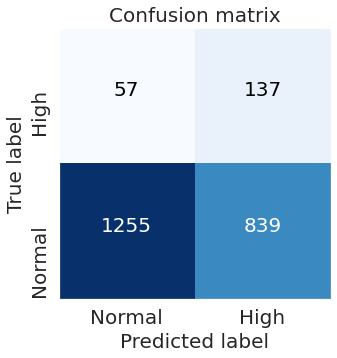

The model performs best with neighbors:  {'C': 0.1}
Recall score on the training set is  0.7341652323580034
Results after fine tuning
Recall for test set using the best parameter is:  0.75
Precision for test set using the best parameter is:  0.14
Accuracy for test set using the best parameter is:  60.0 %


In [0]:
model_lr_l1 = LogisticRegression(penalty = 'l1', C = 1, solver = 'saga', max_iter = 7000)
model_lr_l1.fit(X_train_std, Y_train)
Y_pred = model_lr_l1.predict(X_test_std)

evaluation_metrics(Y_pred, Y_test)

#fine tuning of hyperparameter C
parameters = {'C' : [0.01,0.1,1,10]}
best_param_l1, best_score_train_l1 = fine_tune_function(model_lr_l1, parameters)

#training model using best parameter and testing on test set
model_lr_l1 = LogisticRegression(penalty = 'l1', C = best_param_l1['C'], solver = 'saga', max_iter = 7000)
model_lr_l1.fit(X_train_std, Y_train)
Y_pred = model_lr_l1.predict(X_test_std)
best_score_test_l1 = recall_score(Y_test, Y_pred)
best_score_acc_l1 = accuracy_score(Y_test,Y_pred)
best_score_precison_l1 = precision_score(Y_test, Y_pred)

print("Results after fine tuning")
#evaluation - show confusion matrix for best score
print("Recall for test set using the best parameter is: ", round(best_score_test_l1,2))
print("Precision for test set using the best parameter is: ", round(best_score_precison_l1,2))
print("Accuracy for test set using the best parameter is: ", round(best_score_acc_l1,2)*100,'%')

In [0]:
#probability of model is given in the order given by
model_lr_l1.classes_

array([0, 1])

In [0]:
#predicting the probabilty of test sample to be class 0 or class 1 
Y_proba_l1 = model_lr_l1.predict_proba(X_test_std)

In [0]:
fpr_l1, tpr_l1, thresholds = roc_curve(Y_test_ohe.iloc[:,1], Y_proba_l1[:,1])
auc_l1 = round(roc_auc_score(Y_test_ohe.iloc[:,1], Y_proba_l1[:,1])*100,4)
print("Area Under curve for ROC using model Logistic Regression with l1 is ", auc_l1, "%")

Area Under curve for ROC using model Logistic Regression with l1 is  72.7112 %


## **5.2 Logistic regression with L2**

Logistic Regression with L2 penalty only shrinks the coeficients, they are not zero but the value could be significanlty low in some cases




Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.60      0.74      2094
           1       0.14      0.71      0.23       194

    accuracy                           0.61      2288
   macro avg       0.55      0.65      0.48      2288
weighted avg       0.89      0.61      0.69      2288


Recall Score:  0.71
Confusion matrix, without normalization
Confusion Matrix:  [[1252  842]
 [  57  137]]


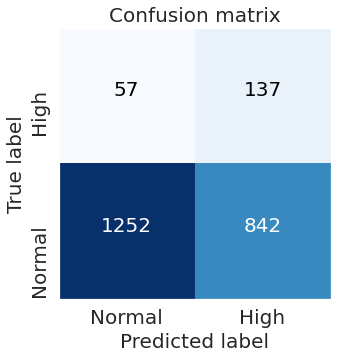

The model performs best with neighbors:  {'C': 0.01}
Recall score on the training set is  0.6911646586345381
Results after fine tuning
Recall for test set using the best parameter is:  0.72
Accuracy for test set using the best parameter is:  61.0 %


In [0]:
model_lr_l2 = LogisticRegression(penalty = 'l2', C = 1, solver = 'saga', max_iter = 7000)
model_lr_l2.fit(X_train_std, Y_train)
Y_pred = model_lr_l2.predict(X_test_std)

evaluation_metrics(Y_pred, Y_test)
parameters = {'C' : [0.01,0.1,1,10]}
best_param_l2, best_score_train_l2 = fine_tune_function(model_lr_l2, parameters)

#training model using best parameter and testing on test set
model_lr_l2 = LogisticRegression(penalty = 'l2', C = best_param_l2['C'], solver = 'saga', max_iter = 7000)
model_lr_l2.fit(X_train_std, Y_train)
Y_pred = model_lr_l2.predict(X_test_std)
best_score_test_l2 = recall_score(Y_test, Y_pred)
best_score_acc_l2 = accuracy_score(Y_test, Y_pred)
best_score_precison_l2 = precision_score(Y_test, Y_pred)

print("Results after fine tuning")
print("Recall for test set using the best parameter is: ", round(best_score_test_l2,2))
print("Accuracy for test set using the best parameter is: ", round(best_score_acc_l2,2)*100,'%')

In [0]:
#probability of model is given in the order given by
model_lr_l2.classes_

array([0, 1])

In [0]:
#predicting the probabilty of test sample to be class 0 or class 1 
Y_proba_l2 = model_lr_l2.predict_proba(X_test_std)

In [0]:
fpr_l2, tpr_l2, thresholds = roc_curve(Y_test_ohe.iloc[:,1], Y_proba_l2[:,1])
auc_l2 = round(roc_auc_score(Y_test_ohe.iloc[:,1], Y_proba_l2[:,1])*100,4)
print("Area Under curve for ROC using model Logistic Regression with l2 is ", auc_l2, "%")

Area Under curve for ROC using model Logistic Regression with l2 is  71.8154 %


In [0]:
fpr_l1.size

333

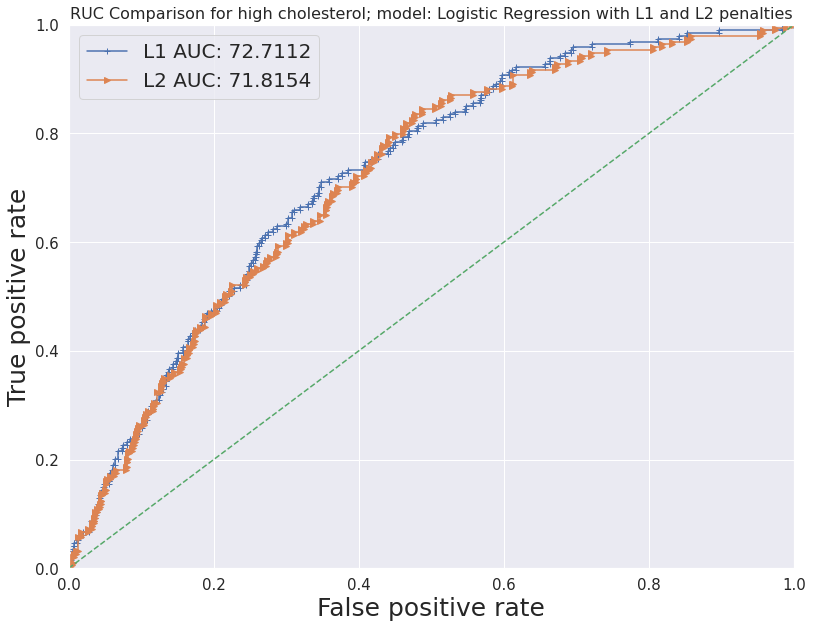

In [0]:
#comparing ROC curve for high cholesterol class
sns.set(color_codes=True)
plt.figure(figsize = (13,10))
plt.plot(fpr_l1, tpr_l1, marker = '+', label = "L1 AUC: {}".format(auc_l1))
plt.plot(fpr_l2, tpr_l2, marker = '>', label = "L2 AUC: {}".format(auc_l2))
plt.xlim(0,1)
plt.ylim(0,1)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle = '--')
plt.title("RUC Comparison for high cholesterol; model: Logistic Regression with L1 and L2 penalties",size = 16)
plt.xlabel('False positive rate', size = 25)
plt.ylabel('True positive rate', size = 25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 20)
plt.show()

## 6. **Non-Linear Methods of Classification**
When the decison boundary is not linear, tree based or other models like kNN or Suport Vector Machined (with non-linear kernels) are used for classification. For the first case we use tree based methods - Random Forest and XGBoost. Both these methods are ensemble methods - where multiple descion trees are trained

## **6.1 Random Forest Classifier**
Random Forest Classifier is bagging method, where trees are trained in a parallel way - on random subset of data

**Paramters:**
1. n_estimators: it determines the number of trees to be trained in the model
2. max_depth: it detrmined the number of nodes in each each tree. It can be a controlling factor to prevent overfitting of the model

Both of the above paramters are fine tuned

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.54      0.70      2094
           1       0.13      0.76      0.23       194

    accuracy                           0.56      2288
   macro avg       0.55      0.65      0.46      2288
weighted avg       0.89      0.56      0.66      2288


Recall Score:  0.76
Confusion matrix, without normalization
Confusion Matrix:  [[1140  954]
 [  46  148]]


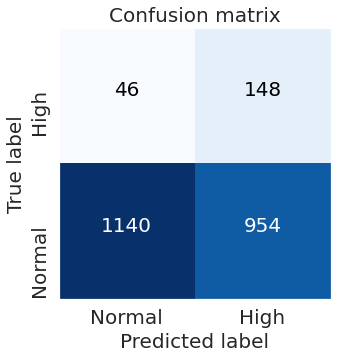

The model performs best with neighbors:  {'max_depth': 3, 'n_estimators': 120}
Recall score on the training set is  0.8086919104991395
Results after fine tuning
Recall for test set using the best parameter is:  0.81
Accuracy for test set using the best parameter is:  0.55
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.53      0.69      2094
           1       0.14      0.81      0.24       194

    accuracy                           0.55      2288
   macro avg       0.55      0.67      0.46      2288
weighted avg       0.90      0.55      0.65      2288


Recall Score:  0.81
Confusion matrix, without normalization
Confusion Matrix:  [[1112  982]
 [  37  157]]


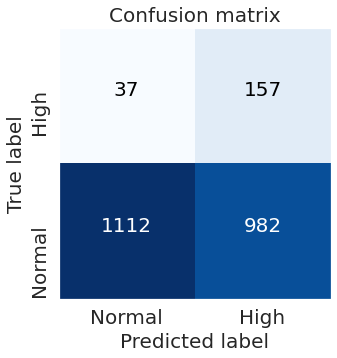

True

In [0]:
#Random Forest Classifier. This does not need standardized data
model_RFC = RandomForestClassifier(n_estimators=80,max_depth=5, random_state=1)
model_RFC.fit(X_train,Y_train)
Y_pred=model_RFC.predict(X_test)

evaluation_metrics(Y_pred,Y_test)

parameters = {'max_depth' : [3,5,7,10], 'n_estimators' : [10,50,80,120,100]}
best_param_RFC, best_score_train_RFC= fine_tune_function(model_RFC, parameters)

#training model using best parameter and testing on test set
model_RFC = RandomForestClassifier(n_estimators=80,max_depth = best_param_RFC['max_depth'], random_state=1)
model_RFC.fit(X_train, Y_train)
Y_pred = model_RFC.predict(X_test)
best_score_test_RFC = recall_score(Y_test, Y_pred)
best_score_acc_RFC = accuracy_score(Y_test, Y_pred)
best_score_precision_RFC = precision_score(Y_test,Y_pred)

print("Results after fine tuning")

print("Recall for test set using the best parameter is: ", round(best_score_test_RFC,2))
print("Accuracy for test set using the best parameter is: ", round(best_score_acc_RFC,2))

#confusion matric after Fine Tuning

evaluation_metrics(Y_pred, Y_test)

In [0]:
#probability of model is given in the order given by
model_RFC.classes_

array([0, 1])

In [0]:
#predicting the probabilty of test sample to be class 0 or class 1 
Y_proba_RFC = model_RFC.predict_proba(X_test_std)

In [0]:
fpr_RFC, tpr_RFC, thresholds = roc_curve(Y_test_ohe.iloc[:,1], Y_proba_RFC[:,1])
auc_RFC = round(roc_auc_score(Y_test_ohe.iloc[:,1], Y_proba_RFC[:,1])*100,4)
print("Area Under curve for ROC using model Random Forest Classifier is ", auc_RFC, "%")

Area Under curve for ROC using model Random Forest Classifier is  64.689 %


## **6.2 XGBoost**

XGBoost works on the priciple of boosting, where trees are trained sequentially. It is trained using library xgboost

**Parameters:**
1. ETA: Learning Rate
2. Gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
3. Max_depth: it determines the number of nodes in a tree
4. eval_metric: it is useful for validation of data. We use area under the precision recall curve (which is different startegy as compared to other models in this notebook; XGBoost library doesn't provide recall as an option - AUCPR is the closest to our strategy)
5. objective: it determines the kind of loss function to be used: we use binary sigmoidal function (logistic)
6. subsample: proportion of training data used for building a tree. It could be used to prevent overfitting

Fine Tuning is done on Gamma, max_depth, subsample.

We build more trees (i.e. boost) until the evaluation metric does not increase for 10 rounds for Cross Val.

For the final training, we create a val set and boost until the aucpr does not decrease for 10 rounds on the val set.


In [0]:
# Training and test sets
dtrain = xgb.DMatrix(np.array(X_train), label=Y_train)
dtest = xgb.DMatrix(np.array(X_test), label=Y_test)

In [0]:
# Parameters
params = {
    'eta': 0.1, 
    'max_depth': 5,  
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'gamma': 0.5,
    'subsample': 0.8} 

# This is the maximum number of boosting rounds it can do
# It'll never actually get to this
num_boost_round = 999

In [0]:
# A set of parameters to search for
gridsearch_params = [
    (max_depth, gamma, subsample)
    for max_depth in [1,3,5,7]
    for gamma in [0.001, 0.01, 0.1,1]
    for subsample in [0.8, 1]
]

In [0]:
# Grid Search
min_aucpr = -10000
best_params = None
for max_depth, gamma,subsample in gridsearch_params:
    print("CV with max_depth={}, min_gamma={}, min_subsample={}".format(
                             max_depth,
                             gamma, subsample))
    # Update our parameters
    params['max_depth'] = max_depth
    params['gamma'] = gamma
    params['subsample'] = subsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'aucpr'},
        early_stopping_rounds=10
    )
    
    # Update best aucpr
    mean_aucpr = cv_results['test-aucpr-mean'].min()
    boost_rounds = cv_results['test-aucpr-mean'].idxmin()
    print("\taucpr {} for {} rounds".format(mean_aucpr, boost_rounds))
    if mean_aucpr > min_aucpr:
        min_aucpr = mean_aucpr
        best_params = (max_depth,gamma, subsample)
print("Best params: {}, {}, {} aucpr: {}".format(best_params[0], best_params[1], best_params[2], min_aucpr))
params['max_depth'] = best_params[0]
params['gamma'] = best_params[1]
params['subsample'] = best_params[2]

CV with max_depth=1, min_gamma=0.001, min_subsample=0.8
	aucpr 0.5950916 for 0 rounds
CV with max_depth=1, min_gamma=0.001, min_subsample=1
	aucpr 0.5994244 for 0 rounds
CV with max_depth=1, min_gamma=0.01, min_subsample=0.8
	aucpr 0.5950916 for 0 rounds
CV with max_depth=1, min_gamma=0.01, min_subsample=1
	aucpr 0.5994244 for 0 rounds
CV with max_depth=1, min_gamma=0.1, min_subsample=0.8
	aucpr 0.5950916 for 0 rounds
CV with max_depth=1, min_gamma=0.1, min_subsample=1
	aucpr 0.5994244 for 0 rounds
CV with max_depth=1, min_gamma=1, min_subsample=0.8
	aucpr 0.5950916 for 0 rounds
CV with max_depth=1, min_gamma=1, min_subsample=1
	aucpr 0.5994244 for 0 rounds
CV with max_depth=3, min_gamma=0.001, min_subsample=0.8
	aucpr 0.6243247999999999 for 0 rounds
CV with max_depth=3, min_gamma=0.001, min_subsample=1
	aucpr 0.5950992 for 1 rounds
CV with max_depth=3, min_gamma=0.01, min_subsample=0.8
	aucpr 0.6243247999999999 for 0 rounds
CV with max_depth=3, min_gamma=0.01, min_subsample=1
	aucpr 0

In [0]:
# Creating train and val sets
X_train_xgb, X_val_xgb, Y_train_xgb, Y_val_xgb = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [0]:
# Porting to XGBoost dataset format
dtrain_new = xgb.DMatrix(np.array(X_train_xgb), label=Y_train_xgb)
dval = xgb.DMatrix(np.array(X_val_xgb), label=Y_val_xgb)

In [0]:
# Training final model
model_xgb = xgb.train(
    params,
    dtrain_new,
    num_boost_round=num_boost_round,
    evals=[(dval, "Val")],
    early_stopping_rounds=10
)
print("Best AUC: {:.2f} with {} rounds".format(
                 model_xgb.best_score,
    model_xgb.best_iteration+1))

[0]	Val-aucpr:0.678948
Will train until Val-aucpr hasn't improved in 10 rounds.
[1]	Val-aucpr:0.698375
[2]	Val-aucpr:0.697568
[3]	Val-aucpr:0.672017
[4]	Val-aucpr:0.670524
[5]	Val-aucpr:0.690402
[6]	Val-aucpr:0.693511
[7]	Val-aucpr:0.687633
[8]	Val-aucpr:0.681551
[9]	Val-aucpr:0.686511
[10]	Val-aucpr:0.694135
[11]	Val-aucpr:0.690288
Stopping. Best iteration:
[1]	Val-aucpr:0.698375

Best AUC: 0.70 with 2 rounds


In [0]:
# Predicting probabilities
Y_pred = model_xgb.predict(dtest)

#predicting train set
Y_pred_train = model_xgb.predict(dtrain)

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.52      0.68      2094
           1       0.14      0.83      0.24       194

    accuracy                           0.55      2288
   macro avg       0.55      0.68      0.46      2288
weighted avg       0.90      0.55      0.64      2288


Recall Score:  0.83
Confusion matrix, without normalization
Confusion Matrix:  [[1095  999]
 [  33  161]]


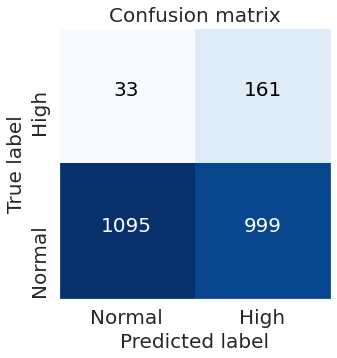

True

In [0]:
evaluation_metrics(np.where(Y_pred > 0.5, 1, 0), Y_test)

In [0]:
best_score_train_xgb = recall_score(Y_train, np.where(Y_pred_train>0.5, 1, 0))
best_score_test_xgb = recall_score(Y_test, np.where(Y_pred>0.5, 1, 0))
best_score_acc_xgb = accuracy_score(Y_test, np.where(Y_pred>0.5,1,0))
best_score_precision_xgb = precision_score(Y_test, np.where(Y_pred>0.5,1,0))
print("Recall for test set using model XGBoost with best parameters: ", round(best_score_test_xgb,2))
print("Accuracy for test set using model XGBoost with best parameters: ", round(best_score_acc_xgb,2))
print("Precision for test set using model XGBoost with best parameters: ", round(best_score_precision_xgb,2))

Recall for test set using model XGBoost with best parameters:  0.83
Accuracy for test set using model XGBoost with best parameters:  0.55
Precision for test set using model XGBoost with best parameters:  0.14


In [0]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

In [0]:
fpr_xgb, tpr_xgb, thresholds = roc_curve(Y_test, Y_pred)
auc_xgb = round(roc_auc_score(Y_test, Y_pred)*100,4)
print("Area Under curve for ROC using model XGBoost is ", auc_xgb, "%")

Area Under curve for ROC using model XGBoost is  71.4017 %


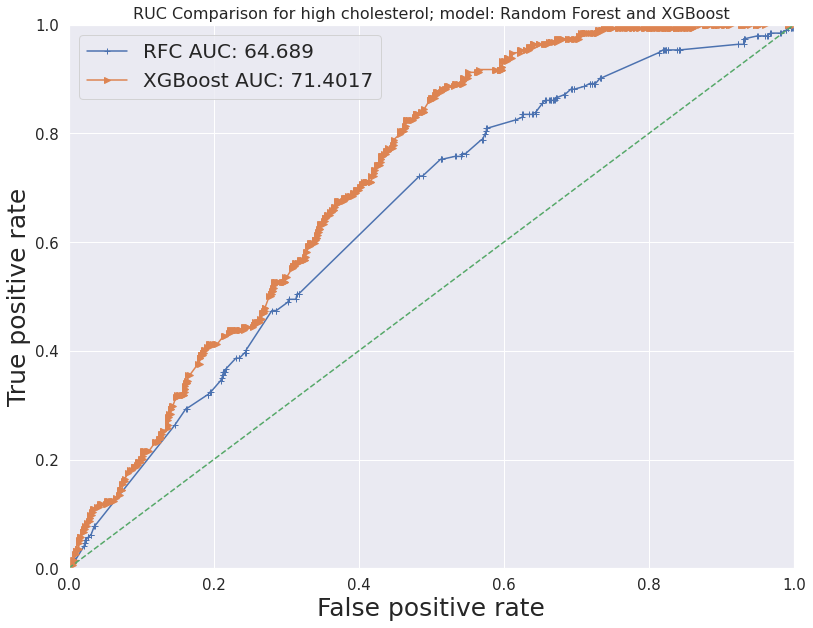

In [0]:
#comparing ROC curve for high cholesterol class
sns.set(color_codes=True)
plt.figure(figsize = (13,10))
plt.plot(fpr_RFC, tpr_RFC, marker = '+', label = "RFC AUC: {}".format(auc_RFC))
plt.plot(fpr_xgb, tpr_xgb, marker = '>', label = "XGBoost AUC: {}".format(auc_xgb))
plt.xlim(0,1)
plt.ylim(0,1)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle = '--')
plt.title("RUC Comparison for high cholesterol; model: Random Forest and XGBoost",size = 16)
plt.xlabel('False positive rate', size = 25)
plt.ylabel('True positive rate', size = 25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 20)
plt.show()

## **k Nearest Neighbors**
It is a simple classification or regression supervised learning model, which determines the class according to the k nearest points.

**Paramters:**
1. n_neighbors: the number of neighnoring points used for decision making
2. metric: The distance metric to be used to calculate the distance between the points and detrmine the nearest neighbor

Fine tuning done on n_neighbors


Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.56      0.70      2094
           1       0.12      0.62      0.19       194

    accuracy                           0.56      2288
   macro avg       0.53      0.59      0.45      2288
weighted avg       0.87      0.56      0.66      2288


Recall Score:  0.62
Confusion matrix, without normalization
Confusion Matrix:  [[1166  928]
 [  73  121]]


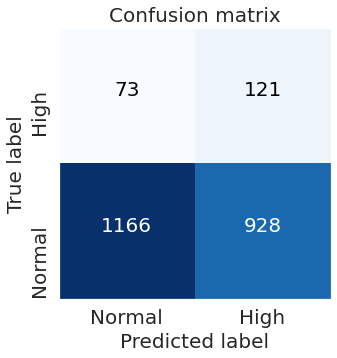

The model performs best with neighbors:  {'n_neighbors': 5}
Recall score on the training set is  0.6411646586345382
Results after fine tuning
Recall for test set using the best parameter is:  0.62
Accuracy for test set using the best parameter is:  0.56


In [0]:
#KNeighborsClassifier
model_kNN = KNeighborsClassifier(n_neighbors= 5, metric='euclidean')
model_kNN.fit(X_train_std,Y_train)
Y_pred=model_kNN.predict(X_test_std)

#Classificaton report and confusion matrix
evaluation_metrics(Y_pred,Y_test)

parameters = {'n_neighbors' : [2,3,4,5,6]}
best_param_kNN, best_score_train_kNN = fine_tune_function(model_kNN, parameters)

#training model using best parameter and testing on test set
model_kNN = KNeighborsClassifier(n_neighbors= best_param_kNN['n_neighbors'], metric='euclidean')
model_kNN.fit(X_train_std, Y_train)
Y_pred = model_kNN.predict(X_test_std)
best_score_test_kNN = recall_score(Y_test, Y_pred)
best_score_acc_kNN = accuracy_score(Y_test, Y_pred)
best_score_precision_kNN = precision_score(Y_test, Y_pred)

print('Results after fine tuning')
print("Recall for test set using the best parameter is: ", round(best_score_test_kNN,2))
print("Accuracy for test set using the best parameter is: ", round(best_score_acc_kNN,2))

In [0]:
#probability of model is given in the order given by
model_kNN.classes_

array([0, 1])

In [0]:
#predicting the probabilty of test sample to be class 0 or class 1 
Y_proba_kNN = model_kNN.predict_proba(X_test_std)

In [0]:
fpr_kNN, tpr_kNN, thresholds = roc_curve(Y_test_ohe.iloc[:,1], Y_proba_kNN[:,1])
auc_kNN = round(roc_auc_score(Y_test_ohe.iloc[:,1], Y_proba_kNN[:,1])*100,4)
print("Area Under curve for ROC using model k nearest neighbours is ", auc_kNN, "%")

Area Under curve for ROC using model k nearest neighbours is  63.6733 %


## **Support Vector Classifier**
Suppurt Vector Machines classify using a hyperplane between two classes. The hyperplace is like a decision boundary. With the help of kernel trick, hyperplans could even be non-linear. Due to the gaussian like distribution of classes as seen in most of the features, we use radial basis function as the non linear kernel

**Paramters:**
1. C = regularizer strength. 

C is fine tuned

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.57      0.72      2094
           1       0.14      0.74      0.23       194

    accuracy                           0.59      2288
   macro avg       0.55      0.66      0.47      2288
weighted avg       0.89      0.59      0.68      2288


Recall Score:  0.74
Confusion matrix, without normalization
Confusion Matrix:  [[1200  894]
 [  51  143]]


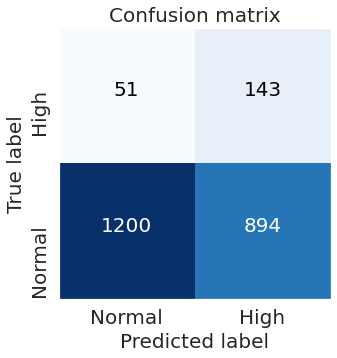

The model performs best with neighbors:  {'C': 0.1}
Recall score on the training set is  0.7559093516924842
Results after fine tuning
Recall for test set using the best parameter is:  0.77
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.53      0.69      2094
           1       0.13      0.77      0.23       194

    accuracy                           0.55      2288
   macro avg       0.55      0.65      0.46      2288
weighted avg       0.89      0.55      0.65      2288


Recall Score:  0.77
Confusion matrix, without normalization
Confusion Matrix:  [[1114  980]
 [  44  150]]


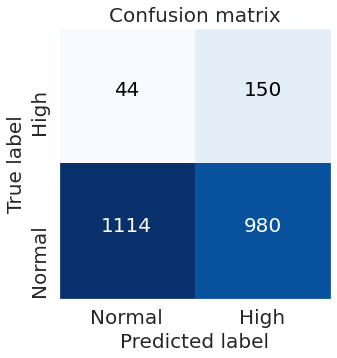

True

In [0]:
#Support Vector Classifier
model_SVC = SVC(C=1.0, kernel='rbf', probability=True)
model_SVC.fit(X_train_std,Y_train)
Y_pred=model_SVC.predict(X_test_std)

evaluation_metrics(Y_pred,Y_test)

parameters = {'C' : [0.01,0.1,10]}
best_param_SVC, best_score_train_SVC = fine_tune_function(model_SVC, parameters)

#training model using best parameter and testing on test set
model_SVC = SVC(C=best_param_SVC['C'], kernel='rbf', probability=True)
model_SVC.fit(X_train_std, Y_train)
Y_pred = model_SVC.predict(X_test_std)
best_score_test_SVC = recall_score(Y_test, Y_pred)
best_score_acc_SVC = accuracy_score(Y_test, Y_pred)
best_score_precision_SVC = precision_score(Y_test, Y_pred)

print('Results after fine tuning')
print("Recall for test set using the best parameter is: ", round(best_score_test_SVC,2))

evaluation_metrics(Y_pred,Y_test)


In [0]:
#probability of model is given in the order given by
model_SVC.classes_

array([0, 1])

In [0]:
#predicting the probabilty of test sample to be class 0 or class 1 
Y_proba_SVC = model_SVC.predict_proba(X_test_std)

In [0]:
fpr_SVC, tpr_SVC, thresholds = roc_curve(Y_test_ohe.iloc[:,1], Y_proba_l2[:,1])
auc_SVC = round(roc_auc_score(Y_test_ohe.iloc[:,1], Y_proba_l2[:,1])*100,4)
print("Area Under curve for ROC using model Support Vector Classifier is ", auc_SVC, "%")

Area Under curve for ROC using model Support Vector Classifier is  71.8154 %


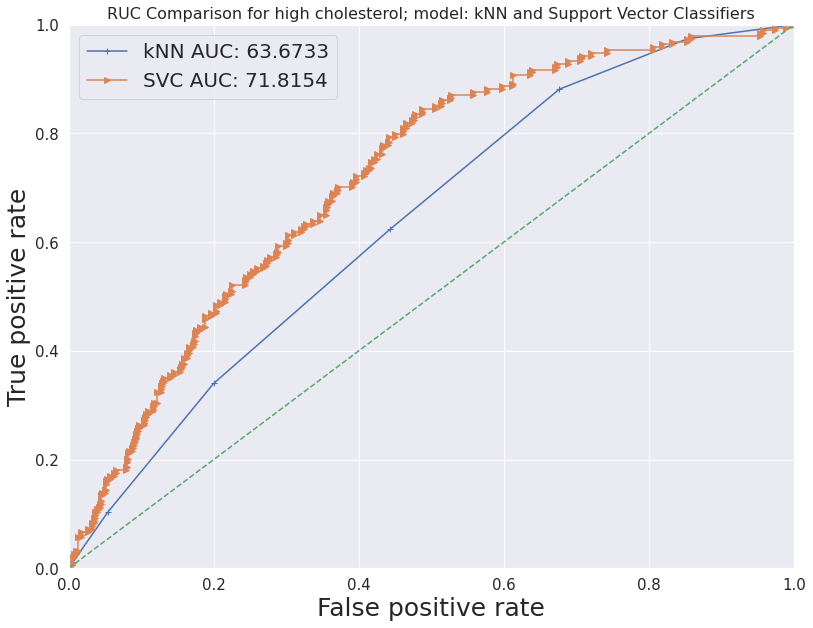

In [0]:
#comparing ROC curve for high cholesterol class
sns.set(color_codes=True)
plt.figure(figsize = (13,10))
plt.plot(fpr_kNN, tpr_kNN, marker = '+', label = "kNN AUC: {}".format(auc_kNN))
plt.plot(fpr_SVC, tpr_SVC, marker = '>', label = "SVC AUC: {}".format(auc_SVC))
plt.xlim(0,1)
plt.ylim(0,1)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle = '--')
plt.title("RUC Comparison for high cholesterol; model: kNN and Support Vector Classifiers",size = 16)
plt.xlabel('False positive rate', size = 25)
plt.ylabel('True positive rate', size = 25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 20)
plt.show()

## **Model Comparison**

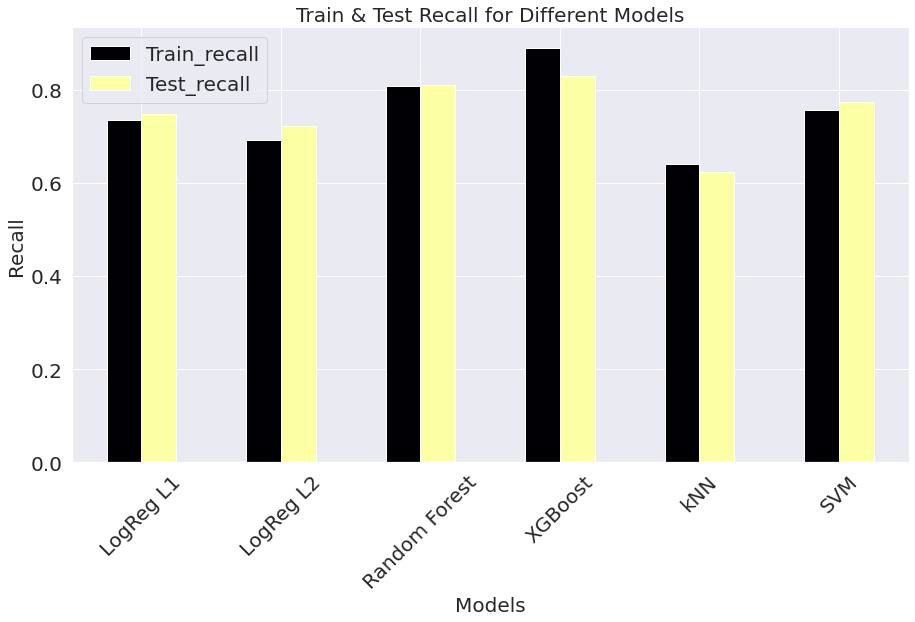

In [0]:
list_train_recall = [best_score_train_l1, best_score_train_l2, best_score_train_RFC, best_score_train_xgb, best_score_train_kNN, best_score_train_SVC]
list_test_recall = [best_score_test_l1, best_score_test_l2,best_score_test_RFC, best_score_test_xgb, best_score_test_kNN, best_score_test_SVC]
models = ['LogReg L1', 'LogReg L2','Random Forest', 'XGBoost', 'kNN', 'SVM']

recall = pd.DataFrame({'Train_recall': list_train_recall, 'Test_recall': list_test_recall}, index = models)


ax=recall.plot.bar(rot=45,figsize=(15,8),title="Train & Test Recall for Different Models",colormap='inferno')
ax.set_title("Train & Test Recall for Different Models", size = 20)
ax.set_xlabel("Models",size=20)
ax.set_ylabel("Recall",size=20)

plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc="best", prop={'size': 20})
plt.show()

Thus, from the above plot we see that random forest and SVM show the best recall on test set, followed by XGBoost, Logistric regression and kNN

Since difference between train and test recall is insignificant, we can conclude that our model is not overfitting

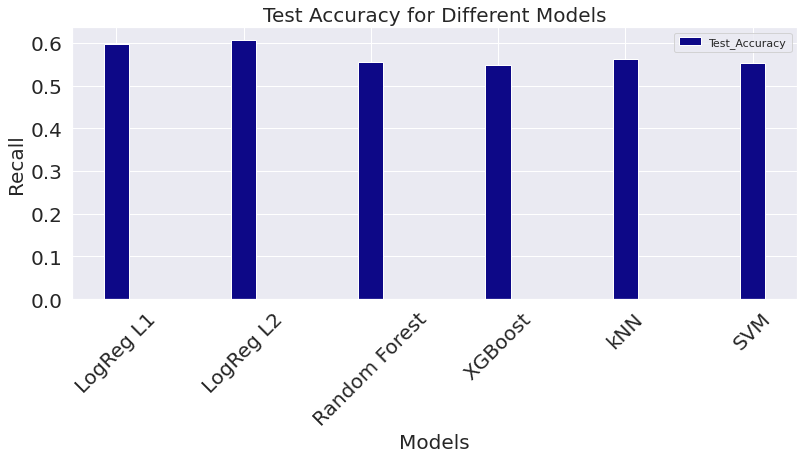

In [0]:
test_accuracy = [best_score_acc_l1, best_score_acc_l2, best_score_acc_RFC, best_score_acc_xgb, best_score_acc_kNN, best_score_acc_SVC]

acc = pd.DataFrame({'Test_Accuracy': test_accuracy}, index = models)

ax=acc.plot.bar(rot=45,figsize=(13,5),title="Test Accuracy for Different Models",colormap='plasma', width = 0.2)
ax.set_title("Test Accuracy for Different Models", size = 20)
ax.set_xlabel("Models",size=20)
ax.set_ylabel("Recall",size=20)

plt.xticks(size=20)
plt.yticks(size=20)
#plt.legend(loc="best", prop={'size': 15})
plt.show()

As far as accuracy is concerned, baseline models (logistic regression) perform better than non-linear models. For better understanding of this different result from the recall, we can look into confusion matrix of any non-linear method, the normal cholesterol class is not classified correctly for at least half of the cases. It is slightly better in linear methods. 

Still the accuracy is not satisfactory for any of the models. Due to the overlapping of two classes in most of the features as seen in EDA, we need to adopt high level classification techniques or introduce feature engineering for the models to be able to perform better.

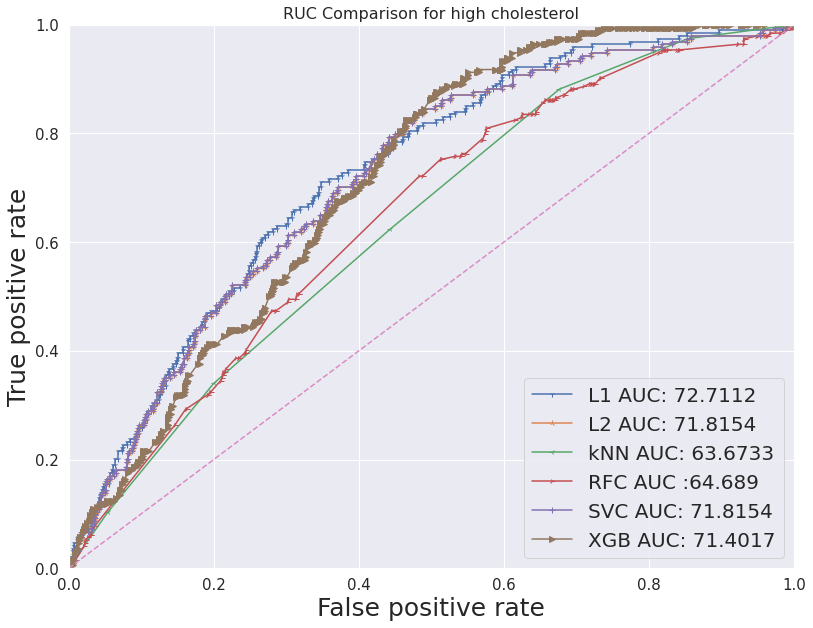

In [0]:
#comparing ROC curve for high cholesterol class
sns.set(color_codes=True)
plt.figure(figsize = (13,10))
plt.plot(fpr_l1, tpr_l1, marker = '1', label = "L1 AUC: {}".format(auc_l1))
plt.plot(fpr_l2, tpr_l2, marker = '2', label = "L2 AUC: {}".format(auc_l2))
plt.plot(fpr_kNN, tpr_kNN,marker= '3', label = "kNN AUC: {}".format(auc_kNN))
plt.plot(fpr_RFC, tpr_RFC, marker = '4', label = 'RFC AUC :{}'.format(auc_RFC))
plt.plot(fpr_SVC, tpr_SVC, marker = '+', label = "SVC AUC: {}".format(auc_SVC))
plt.plot(fpr_xgb, tpr_xgb, marker = '>', label = "XGB AUC: {}".format(auc_xgb))
plt.xlim(0,1)
plt.ylim(0,1)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle = '--')
plt.title("RUC Comparison for high cholesterol",size = 16)
plt.xlabel('False positive rate', size = 25)
plt.ylabel('True positive rate', size = 25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 20)
plt.show()

## **Feature Importance and new models on 10 important features**

In this section, we will see the important features extracted from logistric regression and random forest tree method. The top 10 features will be used to train 2 models - 1 linear and 1 non-linear. 

Top 10 features can make our business model more meaningful if the models perform equally well or better as compared to the models prepared on all 84 features. (Because it is infeassible idea to ask patients 84 questions to determine the cholesterol level)

In [0]:
from sklearn.feature_selection import RFE
rfe = RFE(model_lr_l1, 10, step=1)
rfe = rfe.fit(X_train_std, Y_train)
print(rfe.support_)
print(rfe.ranking_)
features_ = pd.Series(filled_X.columns)
feature_names = features_[rfe.support_]

[False False False False False  True False  True False False False False
 False False False False  True False False  True False False False False
 False False False False False False  True False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False  True False  True False
 False False False False False  True False False False False False False
 False False  True False False False False False False False False]
[16 39 36 35 23  1 31  1 30 37 41 29  9 46 45  4  1 51 13  1 56 18 60 11
 65 53 57 32 28  5  1 22 43 47  3 61 24 67 69 71 73 74 72  1 44 48 49 50
 21 54  8 58 59 15 17 27  1 10  1 25 33 20 62  6 64  1 66 70 12 63 55 52
 68 19  1 42 26 34  2 14 38 40  7]


In [0]:
coef = np.abs(model_lr_l1.coef_).reshape(-1,1)
#print(coef.shape)
feature_importance = coef[rfe.support_]
print(feature_importance)

[[0.27]
 [0.16]
 [0.15]
 [0.13]
 [0.79]
 [0.12]
 [0.12]
 [0.13]
 [0.25]
 [0.12]]


In [0]:
feature_importance = feature_importance.flatten()
feature_importance = pd.Series(feature_importance,index=feature_names)
#print(feature_importance)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)
#indices = np.argsort(feature_importance)[::-1]

RIDAGEYR    0.792702
DMDHHSZE    0.265208
BPXDI3      0.246284
RIAGENDR    0.156245
HIQ011      0.152346
IND235      0.133176
BPXPLS      0.132524
DR1TALCO    0.120668
MGDCGSZ     0.115949
DR1TATOA    0.115604
dtype: float64


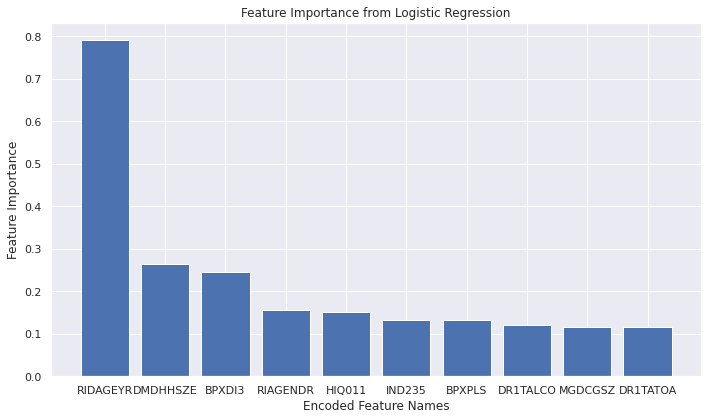

In [0]:
x_ticks = np.arange(0, feature_importance.shape[0])
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x_ticks, feature_importance.values)
ax.set_xticklabels(feature_importance.index)
ax.set_xticks(x_ticks)
ax.set_title("Feature Importance from Logistic Regression")
plt.xlabel('Encoded Feature Names') 
plt.ylabel('Feature Importance') 
fig.tight_layout()
plt.show()

In [0]:
columns = feature_importance.index
df_import_feat = filled_X[columns]

In [0]:
imbalanced_train1, balanced_train1, imbalanced_test1, balanced_test1 = create_splits(df_import_feat, Y, 0.3, 2)

In [0]:
X_train1 = balanced_train1[0]
Y_train1 = balanced_train1[1]

X_test1 = imbalanced_test1[0]
Y_test1 = imbalanced_test1[1]

In [0]:
X_train_std1 = scaler.fit_transform(X_train1)
X_test_std1 = scaler.transform(X_test1)

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.59      0.73      2094
           1       0.14      0.74      0.24       194

    accuracy                           0.60      2288
   macro avg       0.55      0.66      0.48      2288
weighted avg       0.89      0.60      0.69      2288


Recall Score:  0.74
Confusion matrix, without normalization
Confusion Matrix:  [[1229  865]
 [  50  144]]


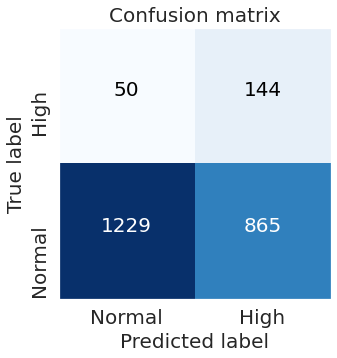

The model performs best with neighbors:  {'C': 0.1}
Recall score on the training set is  0.7341652323580034
Results after fine tuning
Recall for test set using the best parameter is:  0.75


In [0]:
lr_l1_feat = LogisticRegression(penalty = 'l1', C = 1, solver = 'saga', max_iter = 2500)
lr_l1_feat.fit(X_train_std1, Y_train1)
Y_pred_feat = lr_l1_feat.predict(X_test_std1)

evaluation_metrics(Y_pred_feat, Y_test1)
parameters = {'C' : [0.01,0.1,1,10]}
best_param_l1_feat, best_score_train_l1_feat = fine_tune_function(lr_l1_feat, parameters)

#training model using best parameter and testing on test set
lr_l1_feat = LogisticRegression(penalty = 'l2', C = best_param_l1_feat['C'], solver = 'saga', max_iter = 2500)
lr_l1_feat.fit(X_train_std1, Y_train1)
Y_pred_feat = lr_l1_feat.predict(X_test_std1)
best_test_l1_feat = recall_score(Y_test1, Y_pred_feat)
best_acc_l1_feat = accuracy_score(Y_test1,Y_pred_feat)

print("Results after fine tuning")
#evaluation - show confusion matrix for best score
print("Recall for test set using the best parameter is: ", round(best_test_l1_feat,2))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.728


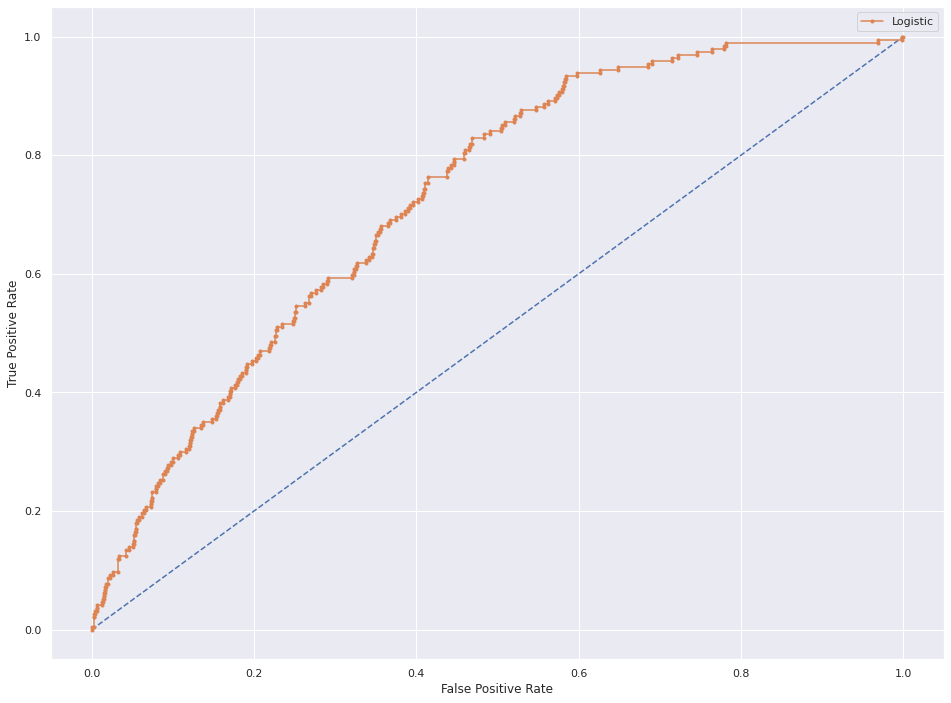

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(Y_test1))]
# predict probabilities
lr_probs_feat = lr_l1_feat.predict_proba(X_test_std1)

# keep probabilities for the positive outcome only
lr_probs_feat = lr_probs_feat[:, 1]

# calculate scores
ns_auc = roc_auc_score(Y_test1, ns_probs)
lr_auc = roc_auc_score(Y_test1, lr_probs_feat)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test1, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test1, lr_probs_feat)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

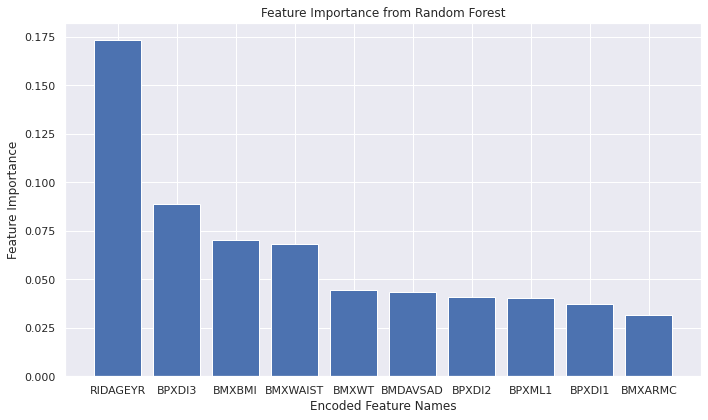

In [0]:
importances = model_RFC.feature_importances_
indices = np.argsort(importances)[::-1][:10]

x_ticks = np.arange(0, len(filled_X.columns[indices]))
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x_ticks, importances[indices])
ax.set_xticklabels(filled_X.columns[indices])
ax.set_xticks(x_ticks)
ax.set_title("Feature Importance from Random Forest")
plt.xlabel('Encoded Feature Names') 
plt.ylabel('Feature Importance') 
fig.tight_layout()
plt.show()

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.56      0.71      2094
           1       0.14      0.79      0.24       194

    accuracy                           0.58      2288
   macro avg       0.55      0.67      0.47      2288
weighted avg       0.90      0.58      0.67      2288


Recall Score:  0.79
Confusion matrix, without normalization
Confusion Matrix:  [[1164  930]
 [  41  153]]


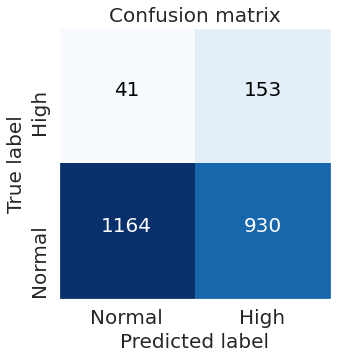

The model performs best with neighbors:  {'max_depth': 3}
Recall score on the training set is  0.8014629948364889
Results after fine tuning
Recall for test set using the best parameter is:  0.83
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.53      0.68      2094
           1       0.14      0.83      0.24       194

    accuracy                           0.55      2288
   macro avg       0.56      0.68      0.46      2288
weighted avg       0.90      0.55      0.64      2288


Recall Score:  0.83
Confusion matrix, without normalization
Confusion Matrix:  [[1100  994]
 [  33  161]]


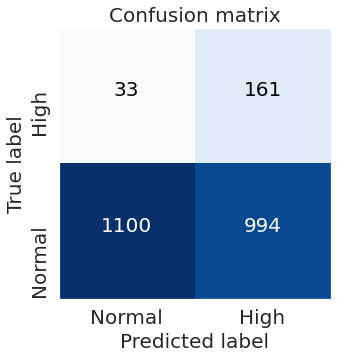

True

In [0]:
#Random Forest Classifier. This does not need standardized data
model_RFC_feat = RandomForestClassifier(max_depth=5, random_state=1)
model_RFC_feat.fit(X_train1,Y_train1)
Y_pred_RFC_feat = model_RFC_feat.predict(X_test1)

evaluation_metrics(Y_pred_RFC_feat,Y_test1)

parameters = {'max_depth' : [3,5,7,10]}
best_param_RFC_feat, best_score_train_RFC_feat = fine_tune_function(model_RFC_feat, parameters)

#training model using best parameter and testing on test set
model_RFC_feat = RandomForestClassifier(max_depth = best_param_RFC_feat['max_depth'], random_state=1)
model_RFC_feat.fit(X_train1, Y_train1)
Y_pred_RFC_feat = model_RFC_feat.predict(X_test1)
best_test_RFC_feat = recall_score(Y_test1, Y_pred_RFC_feat)
best_acc_RFC_feat = accuracy_score(Y_test1, Y_pred_RFC_feat)

print("Results after fine tuning")

print("Recall for test set using the best parameter is: ", round(best_test_RFC_feat,2))

evaluation_metrics(Y_pred_RFC_feat, Y_test1)

In [0]:
Y_pred_proba = model_RFC_feat.predict_proba


In [0]:
Y_test1_ = pd.get_dummies(pd.Series(Y_test1))

In [0]:
Y_test1_

,0,1
1619,1,0
1493,1,0
6209,1,0
3321,0,1
2319,1,0
...,...,...
1962,1,0
4477,1,0
6772,1,0
720,1,0


In [0]:
#predicting the probabilty of test sample to be class 0 or class 1 
Y_proba_RFC_feat = model_RFC_feat.predict_proba(X_test1)

In [0]:
rfc_fpr, rfc_tpr, thresholds = roc_curve(Y_test1_.iloc[:,1], Y_proba_RFC_feat[:,1])
auc_rfc_feat = round(roc_auc_score(Y_test1_.iloc[:,1], Y_proba_RFC_feat[:,1])*100,4)
print("Area Under curve for ROC using model Logistic Regression with l1 is ", auc_rfc_feat, "%")

Area Under curve for ROC using model Logistic Regression with l1 is  72.7924 %


In [0]:
auc_lr = round(roc_auc_score(Y_test1, lr_probs_feat),3)*100

## **Conclusion**
1. Recall of models random forest (0.84) and logistic regression (0.75) using 10 important features is better than the models trained on all 84 features (0.80 & 0.74 respectively)
2. Random Forest was the best non-linear model but with low AUC, here after reducing the features to 10 most important, AUC of random forest has increased to 71.9% from approx 60%
3. There's a limitation with dataset as the observations are only the US, we need to extend the data to other countries to completely validate

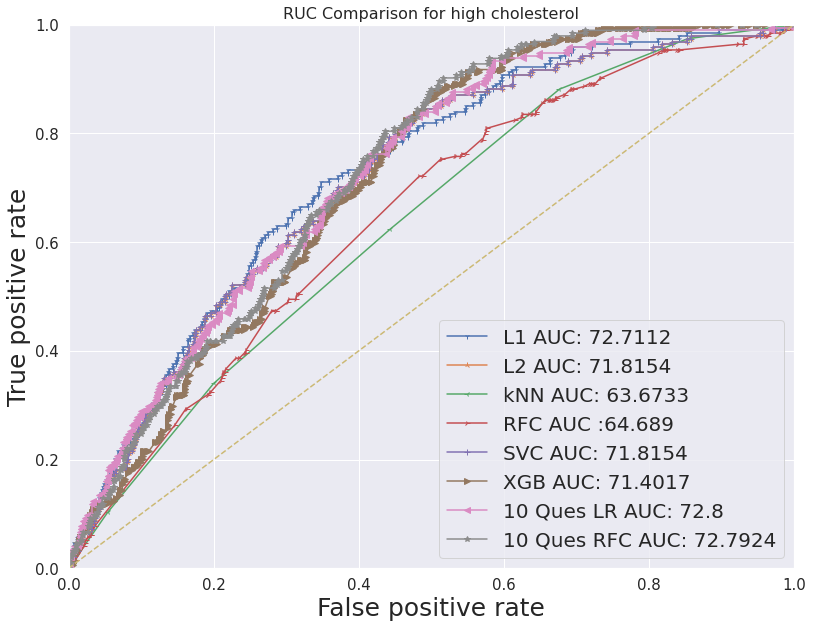

In [0]:
#comparing ROC curve for high cholesterol class for all models using 84 features and 2 models using 10 features
sns.set(color_codes=True)
plt.figure(figsize = (13,10))
plt.plot(fpr_l1, tpr_l1, marker = '1', label = "L1 AUC: {}".format(auc_l1))
plt.plot(fpr_l2, tpr_l2, marker = '2', label = "L2 AUC: {}".format(auc_l2))
plt.plot(fpr_kNN, tpr_kNN,marker= '3', label = "kNN AUC: {}".format(auc_kNN))
plt.plot(fpr_RFC, tpr_RFC, marker = '4', label = 'RFC AUC :{}'.format(auc_RFC))
plt.plot(fpr_SVC, tpr_SVC, marker = '+', label = "SVC AUC: {}".format(auc_SVC))
plt.plot(fpr_xgb, tpr_xgb, marker = '>', label = "XGB AUC: {}".format(auc_xgb))
plt.plot(lr_fpr, lr_tpr, marker = '<', label = "10 Ques LR AUC: {}".format(auc_lr))
plt.plot(rfc_fpr, rfc_tpr, marker = '*', label = "10 Ques RFC AUC: {}".format(auc_rfc_feat))
plt.xlim(0,1)
plt.ylim(0,1)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle = '--')
plt.title("RUC Comparison for high cholesterol",size = 16)
plt.xlabel('False positive rate', size = 25)
plt.ylabel('True positive rate', size = 25)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 20)
plt.show()

**-------------------------------------END-------------------------------------**